## Import Modules

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 
import numpy as np
from scipy.signal import hilbert
import gammatone.filters
from gammatone.gtgram import gtgram
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, LSTM


## Load the Dataset

In [5]:
emotion_map = {
    '01': 'Netral',
    '02': 'Senang',
    '03': 'Terkejut',
    '04': 'Jijik',
    '05': 'Kecewa'
}

In [6]:
paths = []
actors = []
genders = []
emotions = []
intensities = []
repetitions = []

base_dir = 'dataset/IndoWaveSentiment/'
for actor_folder in os.listdir(base_dir):
    actor_path = os.path.join(base_dir, actor_folder)
    if os.path.isdir(actor_path):
        for filename in os.listdir(actor_path):
            if filename.endswith('.wav'):
                paths.append(os.path.join(actor_path, filename))
                parts = filename.replace('.wav', '').split('-')
                actor = parts[0]
                emotion = parts[1]
                intensity = parts[2]
                repetition = parts[3]
                actors.append(actor)
                genders.append('Pria' if int(actor) % 2 == 1 else 'Wanita')
                emotions.append(emotion_map[emotion])
                intensities.append('Normal' if intensity == '01' else 'Strong')
                repetitions.append(repetition)

In [4]:
len(paths)

300

In [5]:
paths[:5]

['dataset/IndoWaveSentiment/Actor_01\\01-01-01-01.wav',
 'dataset/IndoWaveSentiment/Actor_01\\01-01-01-02.wav',
 'dataset/IndoWaveSentiment/Actor_01\\01-01-01-03.wav',
 'dataset/IndoWaveSentiment/Actor_01\\01-01-02-01.wav',
 'dataset/IndoWaveSentiment/Actor_01\\01-01-02-02.wav']

In [6]:
actor[:5]

'10'

In [7]:
genders[:5]

['Pria', 'Pria', 'Pria', 'Pria', 'Pria']

In [8]:
emotions[:5]

['Netral', 'Netral', 'Netral', 'Netral', 'Netral']

In [9]:
intensities[:5]

['Normal', 'Normal', 'Normal', 'Strong', 'Strong']

In [10]:
repetitions[:5]

['01', '02', '03', '01', '02']

In [7]:
## Create a dataframe
df = pd.DataFrame({
    'path': paths,
    'aktor': actors,
    'gender': genders,
    'emosi': emotions,
    'intensitas': intensities,
    'repetisi': repetitions
})
df.head()

path aktor gender   emosi  \
0  dataset/IndoWaveSentiment/Actor_01\01-01-01-01...    01   Pria  Netral   
1  dataset/IndoWaveSentiment/Actor_01\01-01-01-02...    01   Pria  Netral   
2  dataset/IndoWaveSentiment/Actor_01\01-01-01-03...    01   Pria  Netral   
3  dataset/IndoWaveSentiment/Actor_01\01-01-02-01...    01   Pria  Netral   
4  dataset/IndoWaveSentiment/Actor_01\01-01-02-02...    01   Pria  Netral   

  intensitas repetisi  
0     Normal       01  
1     Normal       02  
2     Normal       03  
3     Strong       01  
4     Strong       02

In [12]:
df['path'].value_counts()

path
dataset/IndoWaveSentiment/Actor_01\01-01-01-01.wav    1
dataset/IndoWaveSentiment/Actor_07\07-05-01-03.wav    1
dataset/IndoWaveSentiment/Actor_07\07-05-01-01.wav    1
dataset/IndoWaveSentiment/Actor_07\07-04-02-03.wav    1
dataset/IndoWaveSentiment/Actor_07\07-04-02-02.wav    1
                                                     ..
dataset/IndoWaveSentiment/Actor_04\04-02-02-01.wav    1
dataset/IndoWaveSentiment/Actor_04\04-02-01-03.wav    1
dataset/IndoWaveSentiment/Actor_04\04-02-01-02.wav    1
dataset/IndoWaveSentiment/Actor_04\04-02-01-01.wav    1
dataset/IndoWaveSentiment/Actor_10\10-05-02-03.wav    1
Name: count, Length: 300, dtype: int64

In [13]:
df['aktor'].value_counts()

aktor
01    30
02    30
03    30
04    30
05    30
06    30
07    30
08    30
09    30
10    30
Name: count, dtype: int64

In [14]:
df['gender'].value_counts()

gender
Pria      150
Wanita    150
Name: count, dtype: int64

In [15]:
df['emosi'].value_counts()

emosi
Netral      60
Senang      60
Terkejut    60
Jijik       60
Kecewa      60
Name: count, dtype: int64

In [16]:
df['intensitas'].value_counts()

intensitas
Normal    150
Strong    150
Name: count, dtype: int64

In [17]:
df['repetisi'].value_counts()

repetisi
01    100
02    100
03    100
Name: count, dtype: int64

## Exploratory Data Analysis

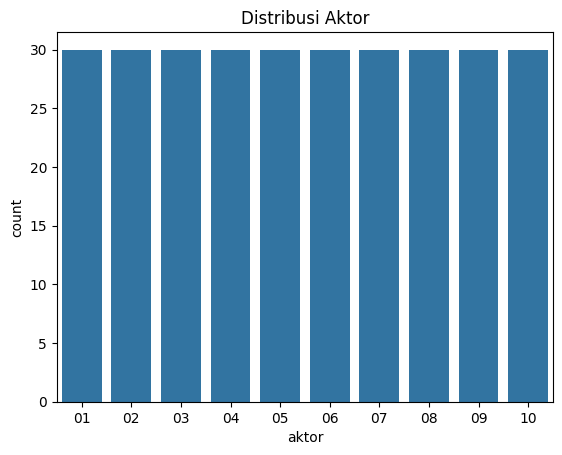

In [18]:
sns.countplot(data=df, x='aktor')
plt.title('Distribusi Aktor')
plt.show()

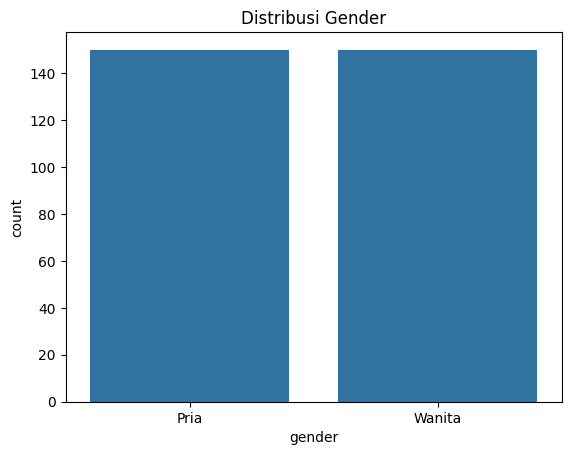

In [19]:
sns.countplot(data=df, x='gender')
plt.title('Distribusi Gender')
plt.show()

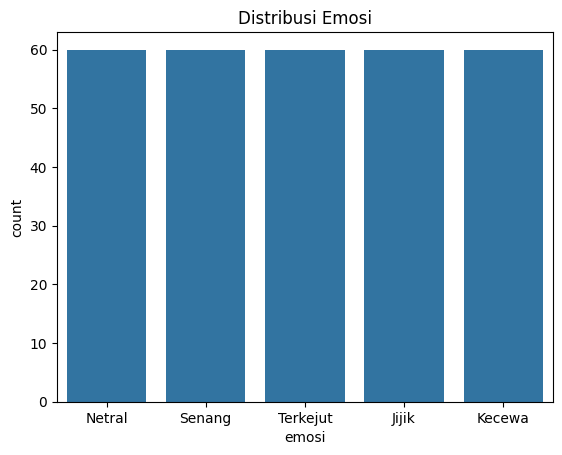

In [20]:
sns.countplot(data=df, x='emosi')
plt.title('Distribusi Emosi')
plt.show()

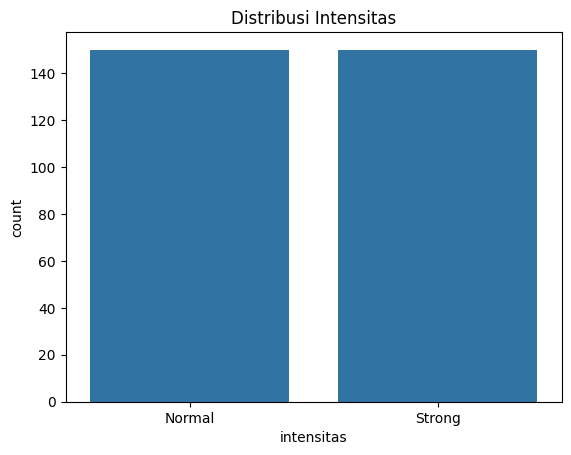

In [21]:
sns.countplot(data=df, x='intensitas')
plt.title('Distribusi Intensitas')
plt.show()

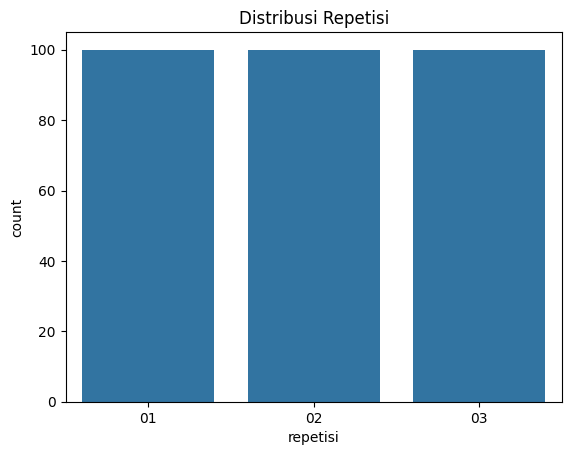

In [22]:
sns.countplot(data=df, x='repetisi')
plt.title('Distribusi Repetisi')
plt.show()

In [23]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
    
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

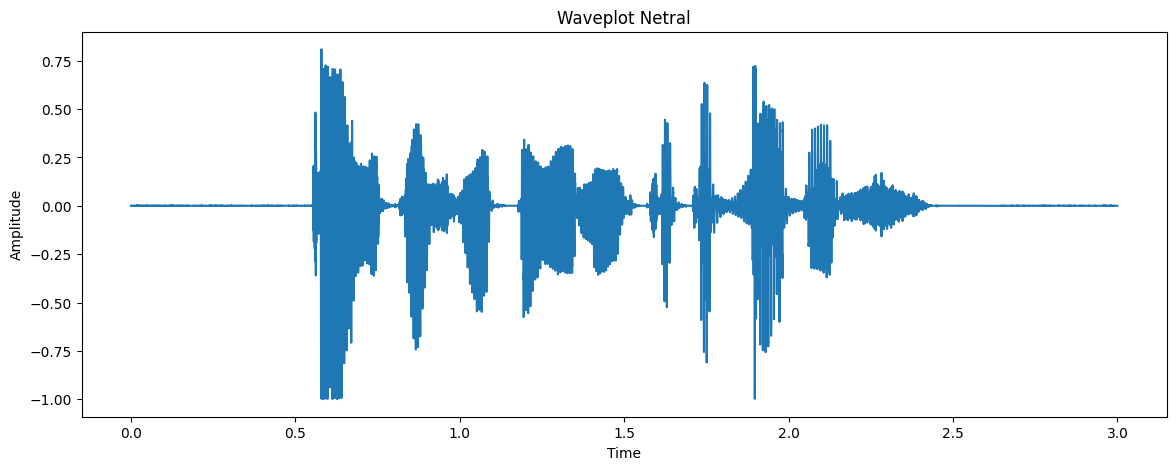

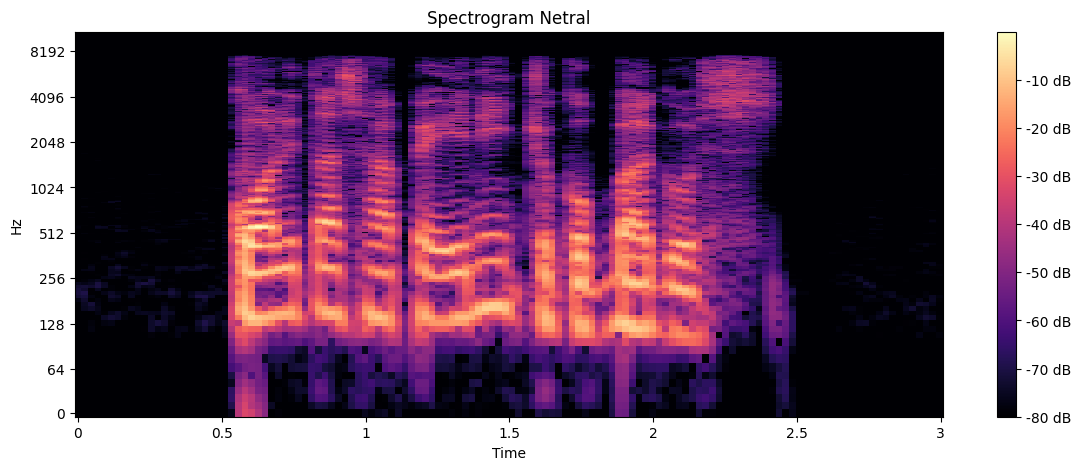

In [24]:
emotion = 'Netral'
paths = np.array(df['path'][df['emosi'] == emotion])[0]

# Load the audio data and get the sampling rate
data, sampling_rate = librosa.load(paths)

# Waveplot
plt.figure(figsize=(14, 5))
plt.title('Waveplot Netral')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(np.arange(len(data)) / sampling_rate, data)
plt.show()

# Spectrogram
plt.figure(figsize=(14, 5))
D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram Netral')
plt.show()
Audio(paths)

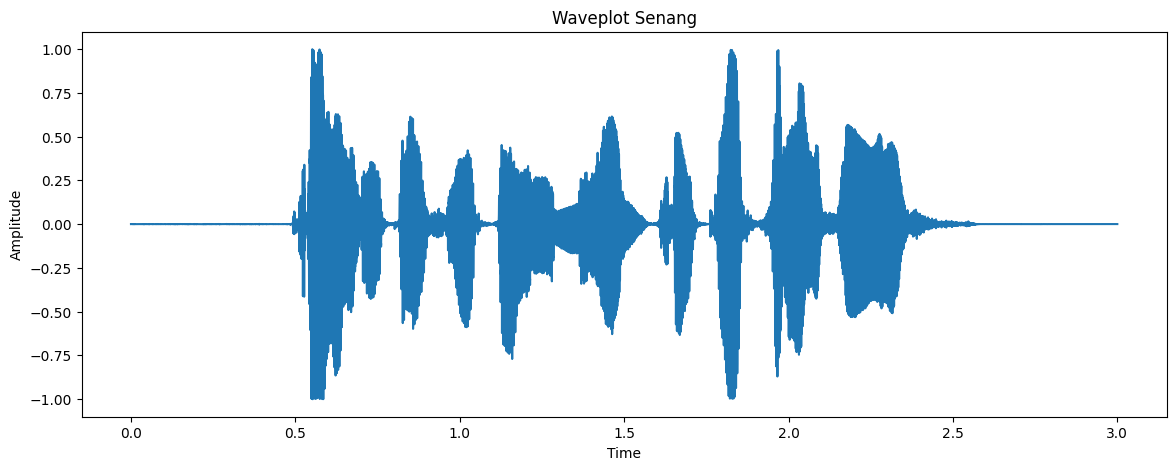

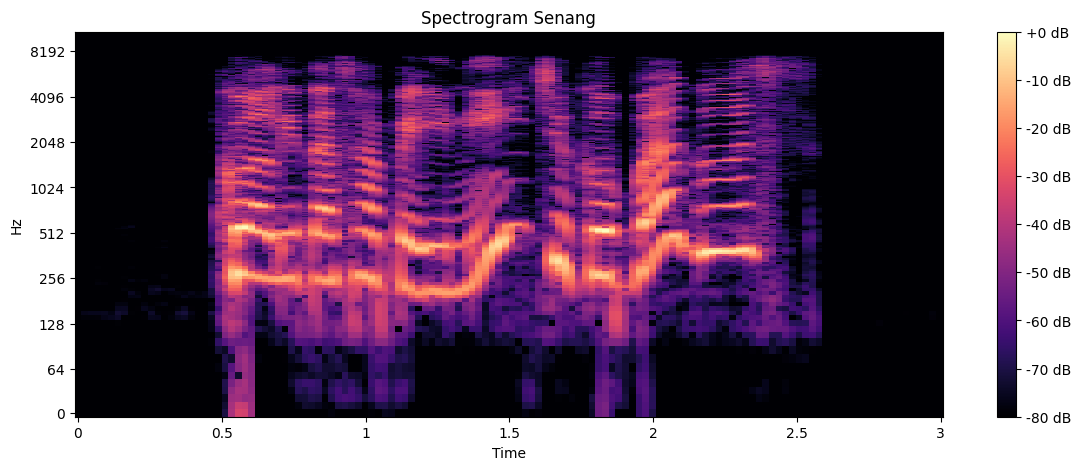

In [25]:
emotion = 'Senang'
paths = np.array(df['path'][df['emosi'] == emotion])[10]

# Load the audio data and get the sampling rate
data, sampling_rate = librosa.load(paths)

# Waveplot
plt.figure(figsize=(14, 5))
plt.title('Waveplot Senang')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(np.arange(len(data)) / sampling_rate, data)
plt.show()

# Spectrogram
plt.figure(figsize=(14, 5))
D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram Senang')
plt.show()
Audio(paths)

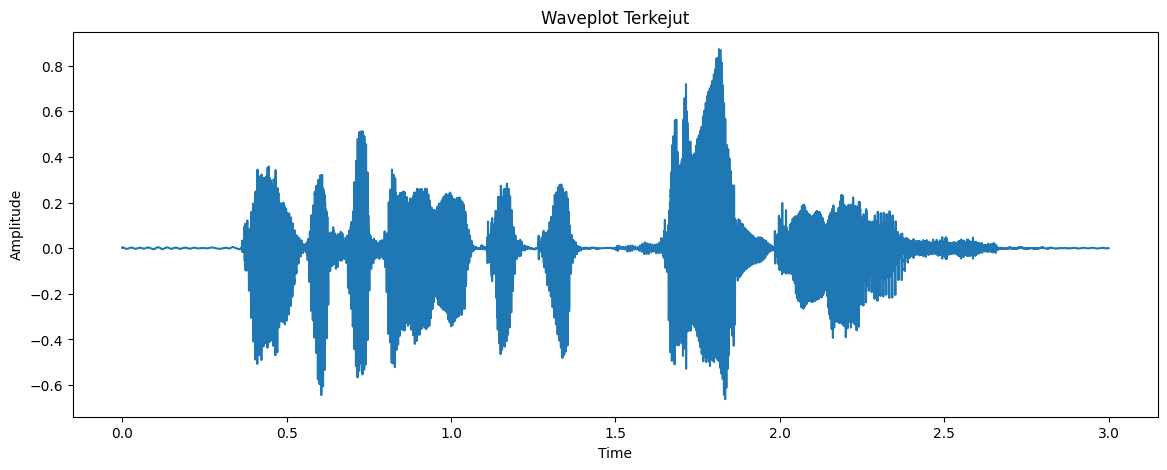

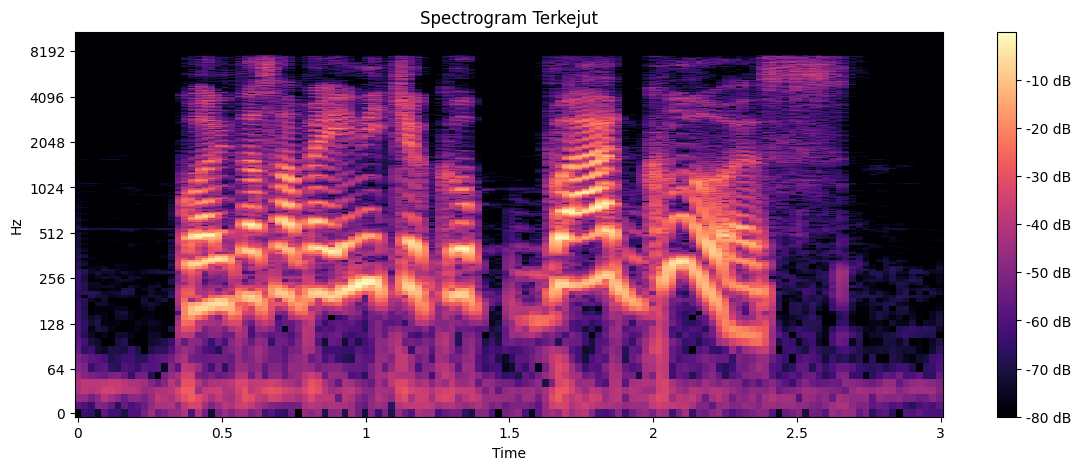

In [26]:
emotion = 'Terkejut'
paths = np.array(df['path'][df['emosi'] == emotion])[16]

# Load the audio data and get the sampling rate
data, sampling_rate = librosa.load(paths)

# Waveplot
plt.figure(figsize=(14, 5))
plt.title('Waveplot Terkejut')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(np.arange(len(data)) / sampling_rate, data)
plt.show()

# Spectrogram
plt.figure(figsize=(14, 5))
D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram Terkejut')
plt.show()
Audio(paths)

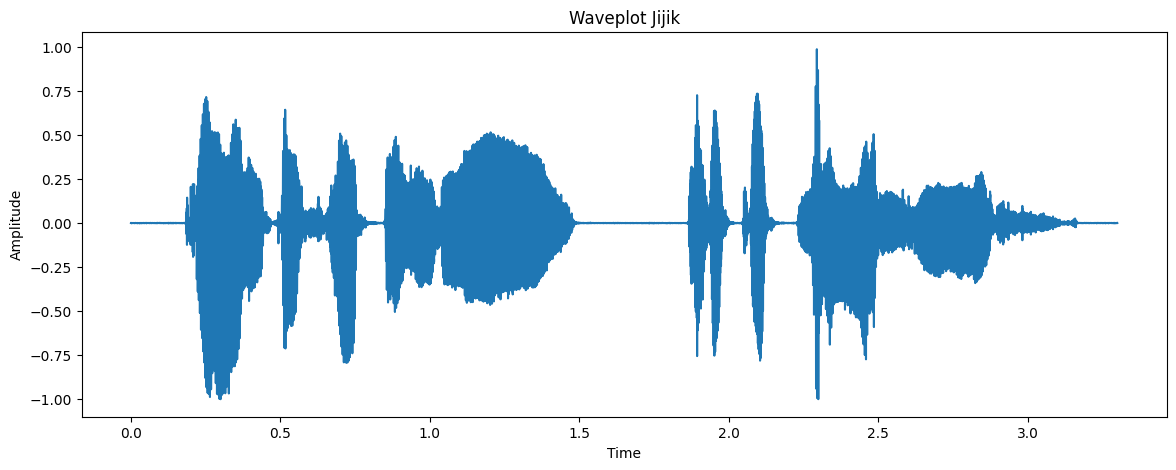

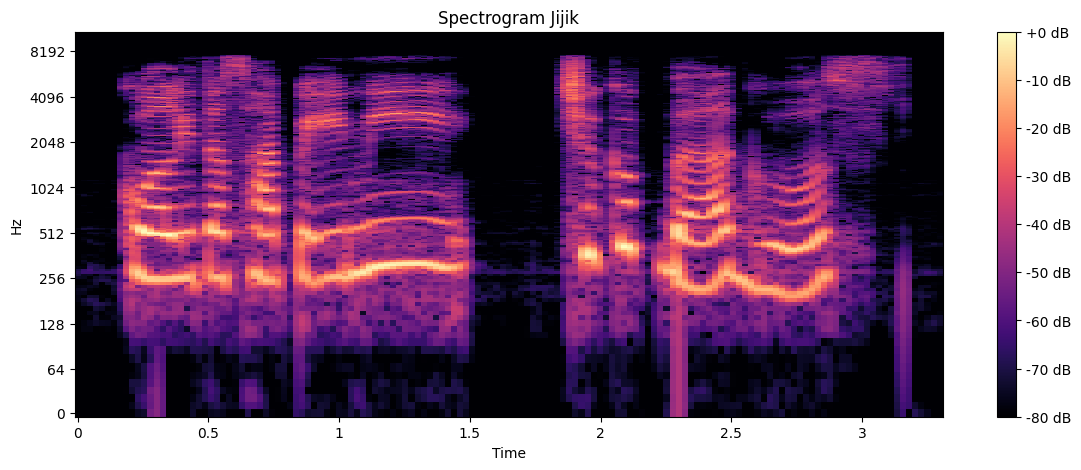

In [27]:
emotion = 'Jijik'
paths = np.array(df['path'][df['emosi'] == emotion])[35]

# Load the audio data and get the sampling rate
data, sampling_rate = librosa.load(paths)

# Waveplot
plt.figure(figsize=(14, 5))
plt.title('Waveplot Jijik')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(np.arange(len(data)) / sampling_rate, data)
plt.show()

# Spectrogram
plt.figure(figsize=(14, 5))
D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram Jijik')
plt.show()
Audio(paths)

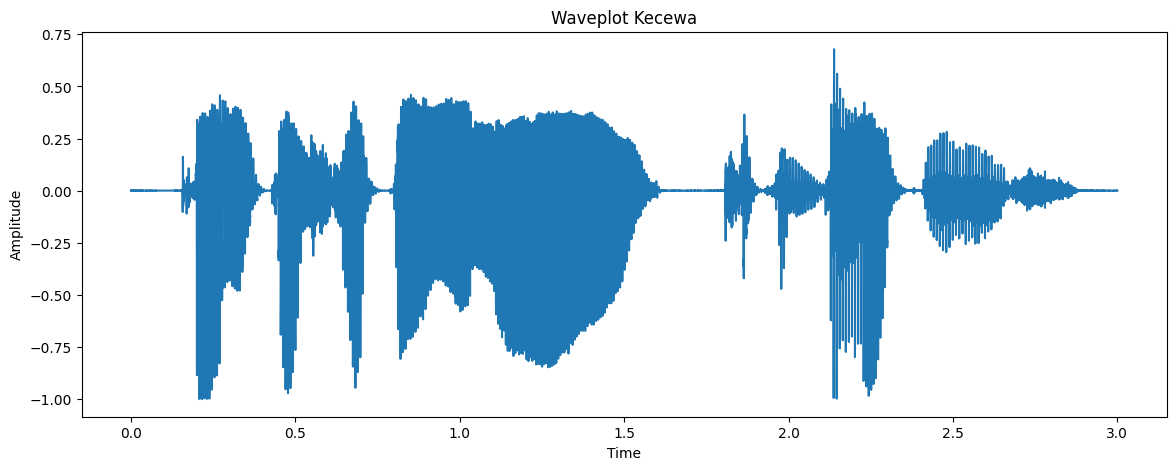

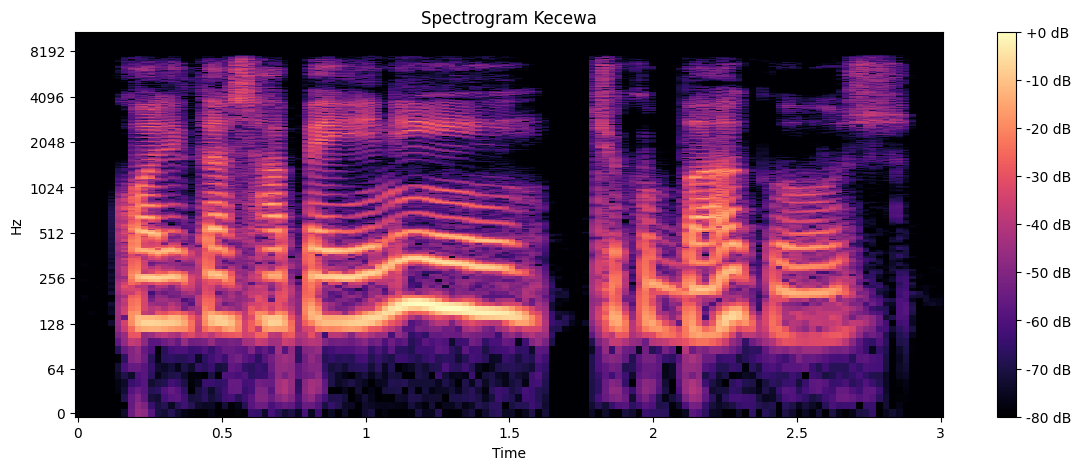

In [28]:
emotion = 'Kecewa'
paths = np.array(df['path'][df['emosi'] == emotion])[50]

# Load the audio data and get the sampling rate
data, sampling_rate = librosa.load(paths)

# Waveplot
plt.figure(figsize=(14, 5))
plt.title('Waveplot Kecewa')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(np.arange(len(data)) / sampling_rate, data)
plt.show()

# Spectrogram
plt.figure(figsize=(14, 5))
D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram Kecewa')
plt.show()
Audio(paths)

## Feature Extraction

### MFCC

In [8]:
def extract_mfcc(filename, n_mfcc=40, duration=3, offset=0.5):
    y, sr = librosa.load(filename, duration=duration, offset=offset)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc.T, axis=0)
    return mfcc_mean

In [30]:
extract_mfcc(df['path'][0])

array([-310.3727   ,   89.42707  ,   -5.002537 ,   45.108185 ,
        -28.18145  ,    1.0313294,  -13.933303 ,   -6.250558 ,
        -18.80358  ,   -8.875765 ,   -7.8153534,  -10.976344 ,
         -1.8067925,  -14.960815 ,    2.9725113,  -13.208093 ,
         -8.190284 ,   -3.730549 ,   -9.972042 ,   -8.8986845,
         -7.6499486,   -6.9391184,   -9.34261  ,   -4.8171773,
         -8.12267  ,   -2.9732068,   -8.181031 ,   -3.566138 ,
         -4.520893 ,   -5.1939845,   -1.5096108,   -6.8051553,
         -1.948944 ,   -4.562287 ,   -2.7517035,   -3.6581802,
         -3.968044 ,   -4.641624 ,   -2.5658946,   -1.1098495],
      dtype=float32)

#### DataFrame

In [9]:
X_mfcc = df['path'].apply(lambda x: extract_mfcc(x))
mfcc = np.stack(X_mfcc.values)
X_mfcc

0      [-310.3727, 89.42707, -5.002537, 45.108185, -2...
1      [-293.58374, 96.594345, -6.6026344, 49.63558, ...
2      [-275.0798, 96.307755, -5.3895497, 52.651905, ...
3      [-300.9955, 86.69134, -4.7884502, 37.07431, -2...
4      [-296.57416, 97.53068, -4.8118505, 43.048214, ...
                             ...                        
295    [-322.98322, 84.86375, 4.3241076, 36.054813, -...
296    [-315.5319, 84.19446, 0.0055141924, 33.952553,...
297    [-342.7631, 94.137825, -1.906536, 30.528961, -...
298    [-367.06488, 98.17489, 11.441321, 34.113586, -...
299    [-342.96817, 88.019485, 0.50365645, 33.983727,...
Name: path, Length: 300, dtype: object

In [10]:
mfcc = [x for x in X_mfcc]
mfcc = np.array(mfcc)
mfcc.shape 

(300, 40)

In [11]:
## input split
mfcc = np.expand_dims(mfcc, -1)
mfcc.shape

(300, 40, 1)

### Multispektrum Hilbert

In [12]:
def extract_hilbert_spectrum(filename, duration=3, offset=0.5):
    y, sr = librosa.load(filename, duration=duration, offset=offset)
    analytic_signal = hilbert(y)
    envelope = np.abs(analytic_signal)
    spectrum = np.abs(np.fft.fft(envelope))
    spectrum = spectrum[:len(spectrum)//2]  # Ambil separuh (nyquist)
    # 15 statistik fitur dari envelope/spectrum
    features = [
        np.mean(envelope),
        np.std(envelope),
        np.max(envelope),
        np.min(envelope),
        np.median(envelope),
        np.percentile(envelope, 25),
        np.percentile(envelope, 75),
        np.mean(spectrum),
        np.std(spectrum),
        np.max(spectrum),
        np.min(spectrum),
        np.median(spectrum),
        np.percentile(spectrum, 25),
        np.percentile(spectrum, 75),
        np.sum(envelope**2)  # energy
    ]
    return np.array(features)  # shape: (15,)

In [10]:
extract_hilbert_spectrum(df['path'][0])

array([9.35449079e-02, 1.40711665e-01, 1.12361681e+00, 1.57270449e-06,
       3.63048278e-02, 8.66984032e-04, 1.27265941e-01, 7.11853727e+00,
       4.47804328e+01, 5.15600843e+03, 1.71812081e-03, 1.18510533e+00,
       2.65310123e-01, 4.58525682e+00, 1.57364233e+03])

#### DataFrame

In [13]:
X_hilbert_spectrum = df['path'].apply(lambda x: extract_hilbert_spectrum(x))
hilbert_spectrum = np.stack(X_hilbert_spectrum.values)
X_hilbert_spectrum

0      [0.09354490786790848, 0.14071166515350342, 1.1...
1      [0.10645010322332382, 0.14868754148483276, 1.2...
2      [0.11742860823869705, 0.1643792986869812, 1.17...
3      [0.10615934431552887, 0.15599283576011658, 1.3...
4      [0.1034325584769249, 0.14503887295722961, 1.09...
                             ...                        
295    [0.13537363708019257, 0.14154790341854095, 1.0...
296    [0.14503295719623566, 0.14839957654476166, 1.2...
297    [0.12333542108535767, 0.12206174433231354, 0.4...
298    [0.10406363010406494, 0.10466554015874863, 0.4...
299    [0.12454231083393097, 0.12590137124061584, 0.5...
Name: path, Length: 300, dtype: object

In [14]:
hilbert_spectrum = [x for x in X_hilbert_spectrum]
hilbert_spectrum = np.array(hilbert_spectrum)
hilbert_spectrum.shape

(300, 15)

In [15]:
## input split
hilbert_spectrum = np.expand_dims(hilbert_spectrum, -1)
hilbert_spectrum.shape

(300, 15, 1)

### Cochleagram

In [16]:
def extract_cochleagram(filename, n_bands=40, duration=3, offset=0.5):
    y, sr = librosa.load(filename, duration=duration, offset=offset)
    # Parameter gtgram: (signal, fs, window_time, hop_time, channels, f_min)
    window_time = 0.025  # 25 ms window
    hop_time = 0.010     # 10 ms hop
    f_min = 50           # Minimum frequency
    # gtgram menghasilkan matriks (n_bands, n_frames)
    cochleagram = gtgram(y, sr, window_time, hop_time, n_bands, f_min)
    # Ambil rata-rata per band (axis=1) untuk vektor fitur
    cochleagram_features = np.mean(cochleagram, axis=1)
    
    return cochleagram_features    

In [15]:
extract_cochleagram(df['path'][0])

array([0.00054579, 0.00248974, 0.01268063, 0.02654825, 0.01802492,
       0.01589227, 0.02186184, 0.02224447, 0.01816266, 0.02364851,
       0.02237021, 0.02170628, 0.01654451, 0.01083946, 0.00726279,
       0.00605292, 0.00449253, 0.00363592, 0.00356404, 0.00332613,
       0.00264121, 0.00188823, 0.00166451, 0.00172009, 0.00247747,
       0.00367745, 0.00359825, 0.00305407, 0.0035006 , 0.00440408,
       0.00399368, 0.00254121, 0.00252163, 0.00306069, 0.00235188,
       0.00169176, 0.00079777, 0.00022022, 0.00010563, 0.00012903])

#### DataFrame

In [17]:
X_cochleagram = df['path'].apply(lambda x: extract_cochleagram(x))
cochleagram = np.stack(X_cochleagram.values)
X_cochleagram

0      [0.0005457932336173398, 0.0024897357673786466,...
1      [0.0006170102994991779, 0.002960471769311592, ...
2      [0.000684701532745724, 0.0032143317306341677, ...
3      [0.0008232640771210891, 0.0021796810543438776,...
4      [0.0007159399233960925, 0.002376610643315366, ...
                             ...                        
295    [0.0003233654224053848, 0.0007264485836519567,...
296    [0.00033681808910627906, 0.0007365669055040537...
297    [0.00014938951975930443, 0.0003301573827922905...
298    [0.00015108883794417023, 0.0003317740607166440...
299    [0.0001956450387799354, 0.00035289785049624084...
Name: path, Length: 300, dtype: object

In [18]:
cochleagram = [x for x in X_cochleagram]
cochleagram = np.array(cochleagram)
cochleagram.shape

(300, 40)

In [19]:
## input split
cochleagram = np.expand_dims(cochleagram, -1)
cochleagram.shape

(300, 40, 1)

### Menggabungkan fitur

In [20]:
# Gabungkan 3 Fitur
def extract_hybrid_features(filename):
    mfcc = extract_mfcc(filename)  # (40,)
    hilbert = extract_hilbert_spectrum(filename)  # (15,)
    cochleagram = extract_cochleagram(filename)  # (64, 192)
    return np.concatenate([mfcc, hilbert, cochleagram])

# Gabungkan 2 Fitur MFCC + Hilbert, MFCC + Cochleagram, Hilbert + Cochleagram
def extract_mfcc_hilbert(filename):
    mfcc = extract_mfcc(filename)  # (40,)
    hilbert = extract_hilbert_spectrum(filename)  # (15,)
    return np.concatenate([mfcc, hilbert])

# Gabungkan 2 Fitur MFCC + Hilbert, MFCC + Cochleagram, Hilbert + Cochleagram
def extract_mfcc_cochleagram(filename):
    mfcc = extract_mfcc(filename)  # (40,)
    cochleagram = extract_cochleagram(filename)  # (64, 192)
    return np.concatenate([mfcc, cochleagram])

# Gabungkan 2 Fitur MFCC + Hilbert, MFCC + Cochleagram, Hilbert + Cochleagram
def extract_hilbert_cochleagram(filename):
    hilbert = extract_hilbert_spectrum(filename)  # (15,)
    cochleagram = extract_cochleagram(filename)  # (64, 192)
    return np.concatenate([hilbert, cochleagram])

In [22]:
extract_hybrid_features(df['path'][0])

array([-3.10372711e+02,  8.94270706e+01, -5.00253677e+00,  4.51081848e+01,
       -2.81814499e+01,  1.03132939e+00, -1.39333029e+01, -6.25055790e+00,
       -1.88035793e+01, -8.87576485e+00, -7.81535339e+00, -1.09763441e+01,
       -1.80679250e+00, -1.49608154e+01,  2.97251129e+00, -1.32080927e+01,
       -8.19028378e+00, -3.73054910e+00, -9.97204208e+00, -8.89868450e+00,
       -7.64994860e+00, -6.93911839e+00, -9.34261036e+00, -4.81717730e+00,
       -8.12267017e+00, -2.97320676e+00, -8.18103123e+00, -3.56613803e+00,
       -4.52089310e+00, -5.19398451e+00, -1.50961077e+00, -6.80515528e+00,
       -1.94894397e+00, -4.56228685e+00, -2.75170350e+00, -3.65818024e+00,
       -3.96804404e+00, -4.64162397e+00, -2.56589460e+00, -1.10984945e+00,
        9.35449079e-02,  1.40711665e-01,  1.12361681e+00,  1.57270449e-06,
        3.63048278e-02,  8.66984032e-04,  1.27265941e-01,  7.11853727e+00,
        4.47804328e+01,  5.15600843e+03,  1.71812081e-03,  1.18510533e+00,
        2.65310123e-01,  

In [25]:
extract_mfcc_hilbert(df['path'][0])

array([-3.10372711e+02,  8.94270706e+01, -5.00253677e+00,  4.51081848e+01,
       -2.81814499e+01,  1.03132939e+00, -1.39333029e+01, -6.25055790e+00,
       -1.88035793e+01, -8.87576485e+00, -7.81535339e+00, -1.09763441e+01,
       -1.80679250e+00, -1.49608154e+01,  2.97251129e+00, -1.32080927e+01,
       -8.19028378e+00, -3.73054910e+00, -9.97204208e+00, -8.89868450e+00,
       -7.64994860e+00, -6.93911839e+00, -9.34261036e+00, -4.81717730e+00,
       -8.12267017e+00, -2.97320676e+00, -8.18103123e+00, -3.56613803e+00,
       -4.52089310e+00, -5.19398451e+00, -1.50961077e+00, -6.80515528e+00,
       -1.94894397e+00, -4.56228685e+00, -2.75170350e+00, -3.65818024e+00,
       -3.96804404e+00, -4.64162397e+00, -2.56589460e+00, -1.10984945e+00,
        9.35449079e-02,  1.40711665e-01,  1.12361681e+00,  1.57270449e-06,
        3.63048278e-02,  8.66984032e-04,  1.27265941e-01,  7.11853727e+00,
        4.47804328e+01,  5.15600843e+03,  1.71812081e-03,  1.18510533e+00,
        2.65310123e-01,  

In [26]:
extract_mfcc_cochleagram(df['path'][0])

array([-3.10372711e+02,  8.94270706e+01, -5.00253677e+00,  4.51081848e+01,
       -2.81814499e+01,  1.03132939e+00, -1.39333029e+01, -6.25055790e+00,
       -1.88035793e+01, -8.87576485e+00, -7.81535339e+00, -1.09763441e+01,
       -1.80679250e+00, -1.49608154e+01,  2.97251129e+00, -1.32080927e+01,
       -8.19028378e+00, -3.73054910e+00, -9.97204208e+00, -8.89868450e+00,
       -7.64994860e+00, -6.93911839e+00, -9.34261036e+00, -4.81717730e+00,
       -8.12267017e+00, -2.97320676e+00, -8.18103123e+00, -3.56613803e+00,
       -4.52089310e+00, -5.19398451e+00, -1.50961077e+00, -6.80515528e+00,
       -1.94894397e+00, -4.56228685e+00, -2.75170350e+00, -3.65818024e+00,
       -3.96804404e+00, -4.64162397e+00, -2.56589460e+00, -1.10984945e+00,
        5.45793234e-04,  2.48973577e-03,  1.26806252e-02,  2.65482464e-02,
        1.80249193e-02,  1.58922667e-02,  2.18618404e-02,  2.22444731e-02,
        1.81626583e-02,  2.36485125e-02,  2.23702056e-02,  2.17062769e-02,
        1.65445147e-02,  

In [27]:
extract_hilbert_cochleagram(df['path'][0])

array([9.35449079e-02, 1.40711665e-01, 1.12361681e+00, 1.57270449e-06,
       3.63048278e-02, 8.66984032e-04, 1.27265941e-01, 7.11853727e+00,
       4.47804328e+01, 5.15600843e+03, 1.71812081e-03, 1.18510533e+00,
       2.65310123e-01, 4.58525682e+00, 1.57364233e+03, 5.45793234e-04,
       2.48973577e-03, 1.26806252e-02, 2.65482464e-02, 1.80249193e-02,
       1.58922667e-02, 2.18618404e-02, 2.22444731e-02, 1.81626583e-02,
       2.36485125e-02, 2.23702056e-02, 2.17062769e-02, 1.65445147e-02,
       1.08394566e-02, 7.26279365e-03, 6.05292036e-03, 4.49253119e-03,
       3.63591855e-03, 3.56404188e-03, 3.32612634e-03, 2.64121191e-03,
       1.88822520e-03, 1.66450934e-03, 1.72009023e-03, 2.47746545e-03,
       3.67744807e-03, 3.59825272e-03, 3.05407083e-03, 3.50059753e-03,
       4.40407686e-03, 3.99368318e-03, 2.54121347e-03, 2.52162547e-03,
       3.06069251e-03, 2.35188332e-03, 1.69175599e-03, 7.97768879e-04,
       2.20222735e-04, 1.05634540e-04, 1.29030074e-04])

#### DataFrame

In [21]:
# 3 Fitur
X_hybrid = df['path'].apply(lambda x: extract_hybrid_features(x))
hybrid = np.stack(X_hybrid.values)
print(hybrid.shape)

(300, 95)


In [22]:
hybrid = np.expand_dims(hybrid, -1)
print(hybrid.shape)

(300, 95, 1)


In [23]:
# 2 Fitur
X_mfcc_hilbert = df['path'].apply(lambda x: extract_mfcc_hilbert(x))
mfcc_hilbert = np.stack(X_mfcc_hilbert.values)
print(mfcc_hilbert.shape)

(300, 55)


In [24]:
mfcc_hilbert = np.expand_dims(mfcc_hilbert, -1)
print(mfcc_hilbert.shape)

(300, 55, 1)


In [25]:
# 2 Fitur
X_mfcc_cochleagram = df['path'].apply(lambda x: extract_mfcc_cochleagram(x))
mfcc_cochleagram = np.stack(X_mfcc_cochleagram.values)
print(mfcc_cochleagram.shape)

(300, 80)


In [26]:
mfcc_cochleagram = np.expand_dims(mfcc_cochleagram, -1)
print(mfcc_cochleagram.shape)

(300, 80, 1)


In [27]:
# 2 Fitur
X_hilbert_cochleagram = df['path'].apply(lambda x: extract_hilbert_cochleagram(x))
hilbert_cochleagram = np.stack(X_hilbert_cochleagram.values)
print(hilbert_cochleagram.shape)

(300, 55)


In [28]:
hilbert_cochleagram = np.expand_dims(hilbert_cochleagram, -1)
print(hilbert_cochleagram.shape)

(300, 55, 1)


## Encoding Label Emosi

In [29]:
enc = OneHotEncoder()
y = enc.fit_transform(df[['emosi']])
y = y.toarray()
y.shape

(300, 5)

In [44]:
print(mfcc.shape)         # (n_samples, 1, 40)
print(hilbert_spectrum.shape)      # (n_samples, 1, 15)
print(cochleagram.shape)  # (n_samples, 64, 192, 1)
print(hybrid.shape)
print(mfcc_hilbert.shape)
print(mfcc_cochleagram.shape)
print(hybrid.shape)

print(y.shape)              # (n_samples, n_classes)

(300, 40, 1)
(300, 15, 1)
(300, 40, 1)
(300, 95, 1)
(300, 55, 1)
(300, 80, 1)
(300, 95, 1)
(300, 5)


## Model CNN MFCC + Hilbert

In [30]:
# Split data
X_train_mfcc_hilbert, X_test_mfcc_hilbert, y_train_mfcc_hilbert, y_test_mfcc_hilbert = train_test_split(mfcc_hilbert, y, test_size=0.2, random_state=42, stratify=y)

In [36]:
input_shape = (mfcc_hilbert.shape[1], 1)

model_cnn_mfcc_hilbert = Sequential([
    Conv1D(256, kernel_size=5, activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),                 
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')  # 5 kelas emosi
])

model_cnn_mfcc_hilbert.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_mfcc_hilbert.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 51, 256)           1536      
                                                                 
 batch_normalization (Batch  (None, 51, 256)           1024      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 25, 256)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 25, 256)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 23, 128)           98432     
                                                                 
 batch_normalization_1 (Bat  (None, 23, 128)           5

In [37]:
history_cnn_mfcc_hilbert = model_cnn_mfcc_hilbert.fit(X_train_mfcc_hilbert, y_train_mfcc_hilbert, validation_data=(X_test_mfcc_hilbert, y_test_mfcc_hilbert), epochs=50, batch_size=32)

Epoch 1/50
8/8 [==============================] - 20s 880ms/step - loss: 2.0856 - accuracy: 0.1583 - val_loss: 1.8578 - val_accuracy: 0.2000
Epoch 2/50
8/8 [==============================] - 2s 297ms/step - loss: 1.7828 - accuracy: 0.2083 - val_loss: 2.4343 - val_accuracy: 0.2000
Epoch 3/50
8/8 [==============================] - 3s 318ms/step - loss: 1.6993 - accuracy: 0.2792 - val_loss: 2.0186 - val_accuracy: 0.2000
Epoch 4/50
8/8 [==============================] - 5s 701ms/step - loss: 1.5923 - accuracy: 0.2458 - val_loss: 2.0746 - val_accuracy: 0.2000
Epoch 5/50
8/8 [==============================] - 3s 321ms/step - loss: 1.5532 - accuracy: 0.3042 - val_loss: 1.7822 - val_accuracy: 0.2000
Epoch 6/50
8/8 [==============================] - 3s 335ms/step - loss: 1.5844 - accuracy: 0.2625 - val_loss: 1.8233 - val_accuracy: 0.2000
Epoch 7/50
8/8 [==============================] - 3s 412ms/step - loss: 1.5640 - accuracy: 0.2667 - val_loss: 1.6553 - val_accuracy: 0.2167
Epoch 8/50
8/8 [===

In [ ]:
# Simpan model yang telah dilatih
model_cnn_mfcc_hilbert.save('dataset/model_CNN_MFCC-Hilbert.h5')

# Simpan label encoder ke file
## np.save('Dataset/label_encoder.npy', label_encoder.classes_)
## np.save('dataset/label_encoder_CNN.npy', enc.categories_[0])

## Kurva Loss dan Akurasi CNN MFCC + Hilbert

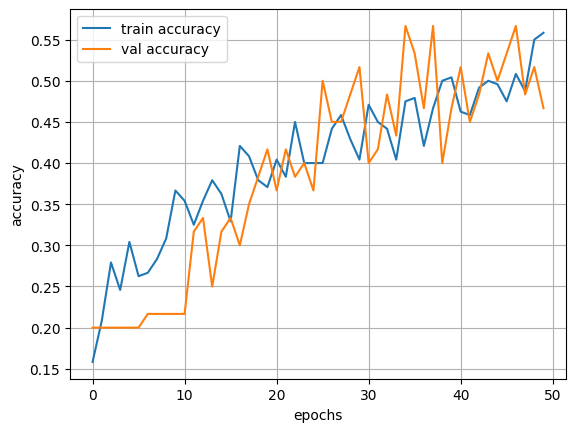

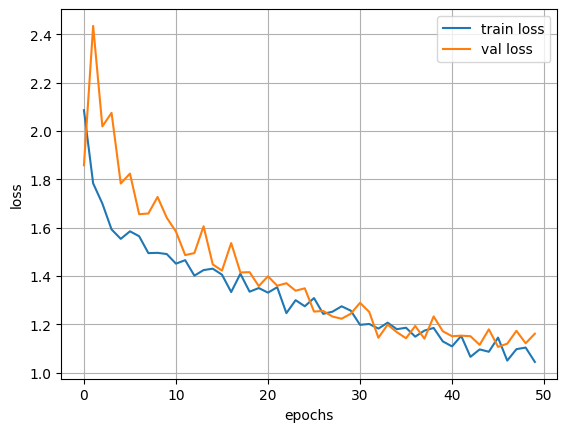

In [38]:
epochs = list(range(len(history_cnn_mfcc_hilbert.history['accuracy'])))
plt.plot(epochs, history_cnn_mfcc_hilbert.history['accuracy'], label='train accuracy')
plt.plot(epochs, history_cnn_mfcc_hilbert.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(epochs, history_cnn_mfcc_hilbert.history['loss'], label='train loss')
plt.plot(epochs, history_cnn_mfcc_hilbert.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.show()

## Evaluasi CNN MFCC + Hilbert

In [39]:
# Prediksi
y_pred_proba_cnn_mfcc_hilbert = model_cnn_mfcc_hilbert.predict(X_test_mfcc_hilbert)
y_pred_cnn_mfcc_hilbert = np.argmax(y_pred_proba_cnn_mfcc_hilbert, axis=1)
y_true_cnn_mfcc_hilbert = np.argmax(y_test_mfcc_hilbert, axis=1)

2/2 [==============================] - 3s 97ms/step


### Confusion Matrix CNN MFCC + Hilbert

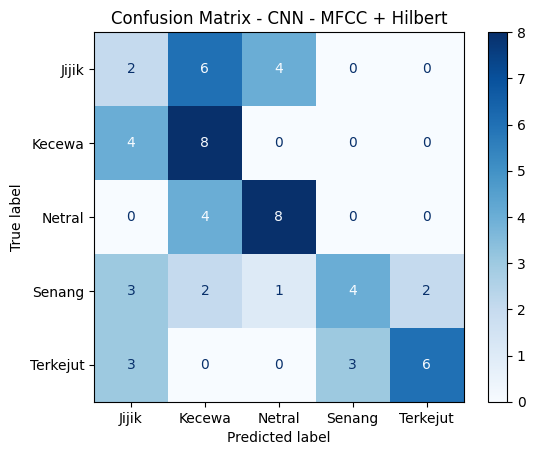

In [40]:
labels = enc.categories_[0]
cm = confusion_matrix(y_true_cnn_mfcc_hilbert, y_pred_cnn_mfcc_hilbert)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - CNN - MFCC + Hilbert')
plt.show()

### Akurasi, Precision, Recall, F1-score (Metrics CNN) MFCC + Hilbert

In [41]:
print("Akurasi :", accuracy_score(y_true_cnn_mfcc_hilbert, y_pred_cnn_mfcc_hilbert))
print("Precision (macro):", precision_score(y_true_cnn_mfcc_hilbert, y_pred_cnn_mfcc_hilbert, average='macro'))
print("Recall (macro):", recall_score(y_true_cnn_mfcc_hilbert, y_pred_cnn_mfcc_hilbert, average='macro'))
print("F1-score (macro):", f1_score(y_true_cnn_mfcc_hilbert, y_pred_cnn_mfcc_hilbert, average='macro'))
print("\nClassification Report:\n", classification_report(y_true_cnn_mfcc_hilbert, y_pred_cnn_mfcc_hilbert, target_names=labels))

Akurasi : 0.4666666666666667
Precision (macro): 0.5006959706959707
Recall (macro): 0.4666666666666666
F1-score (macro): 0.4655438596491228

Classification Report:
               precision    recall  f1-score   support

       Jijik       0.17      0.17      0.17        12
      Kecewa       0.40      0.67      0.50        12
      Netral       0.62      0.67      0.64        12
      Senang       0.57      0.33      0.42        12
    Terkejut       0.75      0.50      0.60        12

    accuracy                           0.47        60
   macro avg       0.50      0.47      0.47        60
weighted avg       0.50      0.47      0.47        60



### AUC-ROC CNN MFCC + Hilbert

In [42]:
auc_roc_cnn_mfcc_hilbert = roc_auc_score(y_test_mfcc_hilbert, y_pred_proba_cnn_mfcc_hilbert, average='macro', multi_class='ovr')
print("AUC-ROC (macro, ovr) :", auc_roc_cnn_mfcc_hilbert)

AUC-ROC (macro, ovr) : 0.8017361111111111


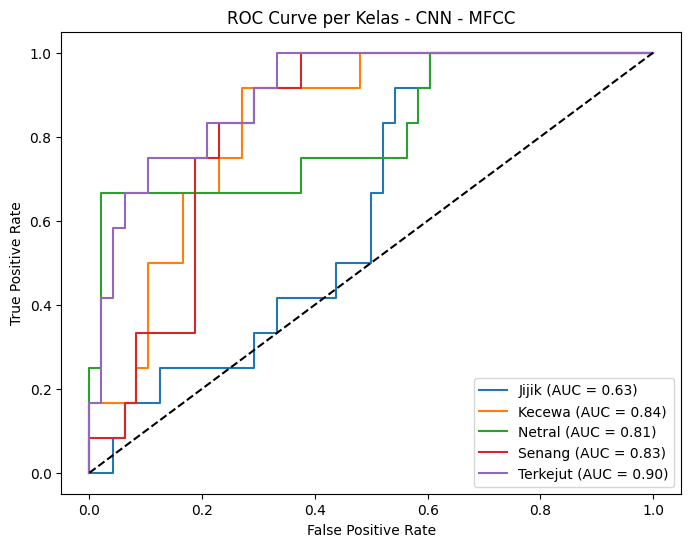

In [43]:
# ROC Curve per kelas
plt.figure(figsize=(8,6))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test_mfcc_hilbert[:, i], y_pred_proba_cnn_mfcc_hilbert[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Kelas - CNN - MFCC')
plt.legend()
plt.show()

## Model CNN MFCC + Cochleagram

In [44]:
# Split data
X_train_mfcc_cochleagram, X_test_mfcc_cochleagram, y_train_mfcc_cochleagram, y_test_mfcc_cochleagram = train_test_split(mfcc_cochleagram, y, test_size=0.2, random_state=42, stratify=y)

In [45]:
input_shape = (mfcc_cochleagram.shape[1], 1)

model_cnn_mfcc_cochleagram = Sequential([
    Conv1D(256, kernel_size=5, activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),                 
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')  # 5 kelas emosi
])

model_cnn_mfcc_cochleagram.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_mfcc_cochleagram.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 76, 256)           1536      
                                                                 
 batch_normalization_2 (Bat  (None, 76, 256)           1024      
 chNormalization)                                                
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 38, 256)           0         
 g1D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 38, 256)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 36, 128)           98432     
                                                                 
 batch_normalization_3 (Bat  (None, 36, 128)          

In [46]:
history_cnn_mfcc_cochleagram = model_cnn_mfcc_cochleagram.fit(X_train_mfcc_cochleagram, y_train_mfcc_cochleagram, validation_data=(X_test_mfcc_cochleagram, y_test_mfcc_cochleagram), epochs=50, batch_size=32)

Epoch 1/50


8/8 [==============================] - 35s 1s/step - loss: 2.4281 - accuracy: 0.1625 - val_loss: 1.5625 - val_accuracy: 0.2000
Epoch 2/50
8/8 [==============================] - 3s 370ms/step - loss: 1.9969 - accuracy: 0.2042 - val_loss: 1.5889 - val_accuracy: 0.2333
Epoch 3/50
8/8 [==============================] - 2s 297ms/step - loss: 1.6153 - accuracy: 0.3000 - val_loss: 1.5444 - val_accuracy: 0.3500
Epoch 4/50
8/8 [==============================] - 5s 627ms/step - loss: 1.5655 - accuracy: 0.3125 - val_loss: 1.4722 - val_accuracy: 0.3333
Epoch 5/50
8/8 [==============================] - 4s 508ms/step - loss: 1.5166 - accuracy: 0.3083 - val_loss: 1.4568 - val_accuracy: 0.4167
Epoch 6/50
8/8 [==============================] - 3s 371ms/step - loss: 1.4350 - accuracy: 0.4042 - val_loss: 1.4353 - val_accuracy: 0.4000
Epoch 7/50
8/8 [==============================] - 3s 336ms/step - loss: 1.4093 - accuracy: 0.3458 - val_loss: 1.3964 - val_accuracy: 0.4000
Epoch 8/50
8/8 [=================

In [ ]:
# Simpan model yang telah dilatih
model_cnn_mfcc_cochleagram.save('dataset/model_CNN_mfcc_cochleagram.h5')

# Simpan label encoder ke file
## np.save('Dataset/label_encoder.npy', label_encoder.classes_)
## np.save('dataset/label_encoder_CNN.npy', enc.categories_[0])

## Kurva Loss dan Akurasi CNN - MFCC + Cochleagram

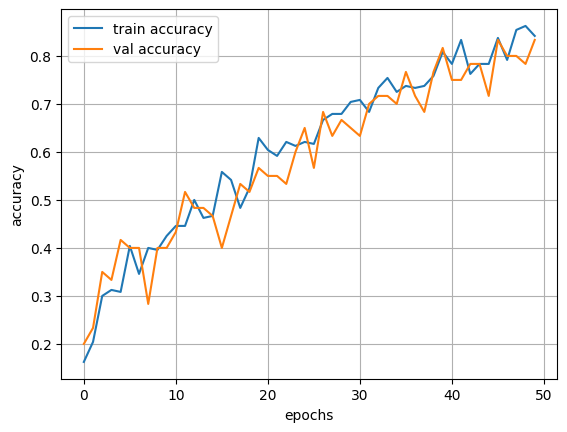

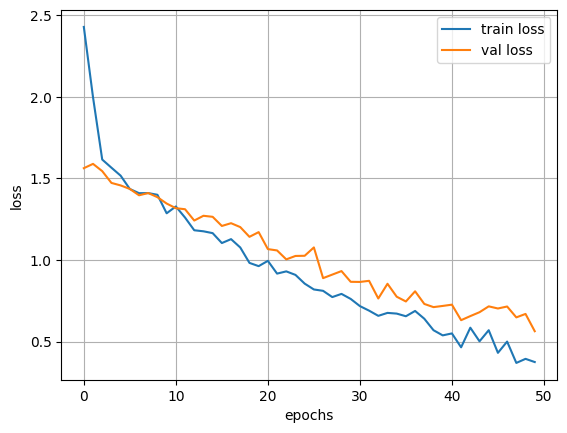

In [47]:
epochs = list(range(len(history_cnn_mfcc_cochleagram.history['accuracy'])))
plt.plot(epochs, history_cnn_mfcc_cochleagram.history['accuracy'], label='train accuracy')
plt.plot(epochs, history_cnn_mfcc_cochleagram.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(epochs, history_cnn_mfcc_cochleagram.history['loss'], label='train loss')
plt.plot(epochs, history_cnn_mfcc_cochleagram.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.show()

## Evaluasi CNN - MFCC + Cochleagram

In [48]:
# Prediksi
y_pred_proba_cnn_mfcc_cochleagram = model_cnn_mfcc_cochleagram.predict(X_test_mfcc_cochleagram)
y_pred_cnn_mfcc_cochleagram = np.argmax(y_pred_proba_cnn_mfcc_cochleagram, axis=1)
y_true_cnn_mfcc_cochleagram = np.argmax(y_test_mfcc_cochleagram, axis=1)

2/2 [==============================] - 2s 161ms/step


### Confusion Matrix CNN - MFCC + Cochleagram

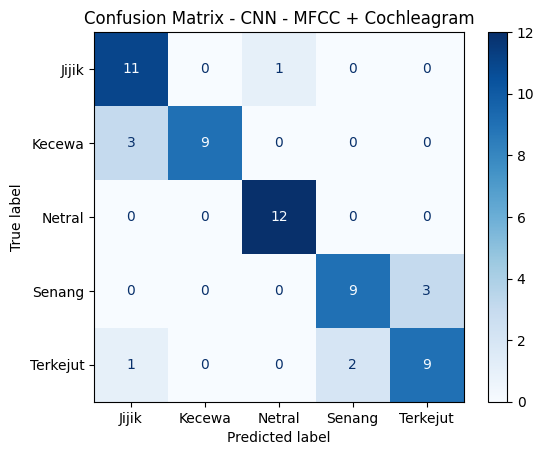

In [49]:
labels = enc.categories_[0]
cm = confusion_matrix(y_true_cnn_mfcc_cochleagram, y_pred_cnn_mfcc_cochleagram)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - CNN - MFCC + Cochleagram')
plt.show()

### Akurasi, Precision, Recall, F1-score (Metrics CNN) MFCC + Cochleagram

In [50]:
print("Akurasi :", accuracy_score(y_true_cnn_mfcc_cochleagram, y_pred_cnn_mfcc_cochleagram))
print("Precision (macro):", precision_score(y_true_cnn_mfcc_cochleagram, y_pred_cnn_mfcc_cochleagram, average='macro'))
print("Recall (macro):", recall_score(y_true_cnn_mfcc_cochleagram, y_pred_cnn_mfcc_cochleagram, average='macro'))
print("F1-score (macro):", f1_score(y_true_cnn_mfcc_cochleagram, y_pred_cnn_mfcc_cochleagram, average='macro'))
print("\nClassification Report:\n", classification_report(y_true_cnn_mfcc_cochleagram, y_pred_cnn_mfcc_cochleagram, target_names=labels))

Akurasi : 0.8333333333333334
Precision (macro): 0.844918414918415
Recall (macro): 0.8333333333333333
F1-score (macro): 0.8329132735219691

Classification Report:
               precision    recall  f1-score   support

       Jijik       0.73      0.92      0.81        12
      Kecewa       1.00      0.75      0.86        12
      Netral       0.92      1.00      0.96        12
      Senang       0.82      0.75      0.78        12
    Terkejut       0.75      0.75      0.75        12

    accuracy                           0.83        60
   macro avg       0.84      0.83      0.83        60
weighted avg       0.84      0.83      0.83        60



### AUC-ROC CNN - MFCC + Cochleagram

In [51]:
auc_roc_cnn_mfcc_cochleagram = roc_auc_score(y_test_mfcc_cochleagram, y_pred_proba_cnn_mfcc_cochleagram, average='macro', multi_class='ovr')
print("AUC-ROC (macro, ovr) :", auc_roc_cnn_mfcc_cochleagram)

AUC-ROC (macro, ovr) : 0.9638888888888888


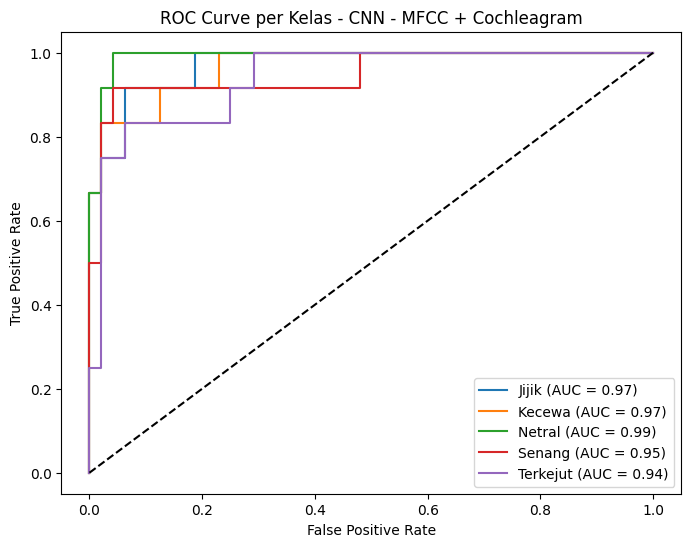

In [52]:
# ROC Curve per kelas
plt.figure(figsize=(8,6))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test_mfcc_cochleagram[:, i], y_pred_proba_cnn_mfcc_cochleagram[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Kelas - CNN - MFCC + Cochleagram')
plt.legend()
plt.show()

## Model CNN Hilbert + Cochleagram

In [32]:
# Split data
X_train_hilbert_cochleagram, X_test_hilbert_cochleagram, y_train_hilbert_cochleagram, y_test_hilbert_cochleagram = train_test_split(hilbert_cochleagram, y, test_size=0.2, random_state=42, stratify=y)

In [53]:
input_shape = (hilbert_cochleagram.shape[1], 1)

model_cnn_hilbert_cochleagram = Sequential([
    Conv1D(256, kernel_size=5, activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),                 
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')  # 5 kelas emosi
])


model_cnn_hilbert_cochleagram.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_hilbert_cochleagram.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 51, 256)           1536      
                                                                 
 batch_normalization_4 (Bat  (None, 51, 256)           1024      
 chNormalization)                                                
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 25, 256)           0         
 g1D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 25, 256)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 23, 128)           98432     
                                                                 
 batch_normalization_5 (Bat  (None, 23, 128)          

In [54]:
history_cnn_hilbert_cochleagram = model_cnn_hilbert_cochleagram.fit(X_train_hilbert_cochleagram, y_train_hilbert_cochleagram, validation_data=(X_test_hilbert_cochleagram, y_test_hilbert_cochleagram), epochs=50, batch_size=32)

Epoch 1/50
8/8 [==============================] - 43s 1s/step - loss: 2.5781 - accuracy: 0.1833 - val_loss: 3.1524 - val_accuracy: 0.2000
Epoch 2/50
8/8 [==============================] - 5s 623ms/step - loss: 1.8617 - accuracy: 0.2000 - val_loss: 2.4161 - val_accuracy: 0.2000
Epoch 3/50
8/8 [==============================] - 3s 389ms/step - loss: 1.7525 - accuracy: 0.2458 - val_loss: 1.7807 - val_accuracy: 0.2000
Epoch 4/50
8/8 [==============================] - 2s 249ms/step - loss: 1.7757 - accuracy: 0.1542 - val_loss: 1.8685 - val_accuracy: 0.2667
Epoch 5/50
8/8 [==============================] - 2s 320ms/step - loss: 1.6859 - accuracy: 0.1917 - val_loss: 1.9265 - val_accuracy: 0.2000
Epoch 6/50
8/8 [==============================] - 2s 216ms/step - loss: 1.6402 - accuracy: 0.2542 - val_loss: 1.7897 - val_accuracy: 0.2167
Epoch 7/50
8/8 [==============================] - 2s 206ms/step - loss: 1.6894 - accuracy: 0.2000 - val_loss: 1.7259 - val_accuracy: 0.2000
Epoch 8/50
8/8 [======

In [ ]:
# Simpan model yang telah dilatih
model_cnn_hilbert_cochleagram.save('dataset/model_CNN_hilbert_Cochleagram.h5')

# Simpan label encoder ke file
## np.save('Dataset/label_encoder.npy', label_encoder.classes_)
## np.save('dataset/label_encoder_CNN.npy', enc.categories_[0])

## Kurva Loss dan Akurasi CNN - Hilbert + Cochleagram

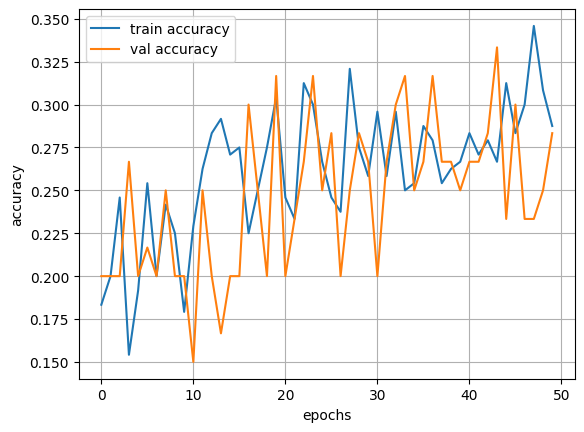

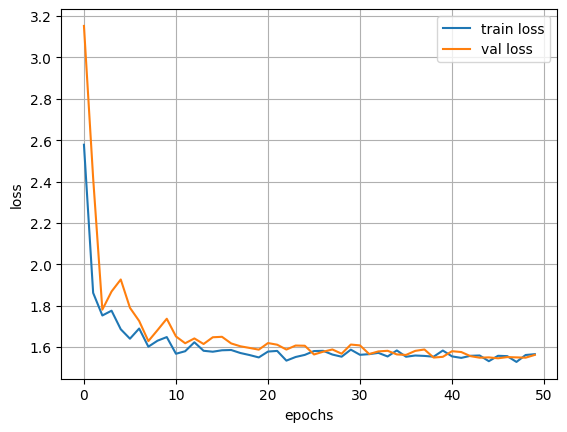

In [55]:
epochs = list(range(len(history_cnn_hilbert_cochleagram.history['accuracy'])))
plt.plot(epochs, history_cnn_hilbert_cochleagram.history['accuracy'], label='train accuracy')
plt.plot(epochs, history_cnn_hilbert_cochleagram.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(epochs, history_cnn_hilbert_cochleagram.history['loss'], label='train loss')
plt.plot(epochs, history_cnn_hilbert_cochleagram.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.show()

## Evaluasi CNN - Hilbert + Cochleagram

In [56]:
# Prediksi
y_pred_proba_cnn_hilbert_cochleagram = model_cnn_hilbert_cochleagram.predict(X_test_hilbert_cochleagram)
y_pred_cnn_hilbert_cochleagram = np.argmax(y_pred_proba_cnn_hilbert_cochleagram, axis=1)
y_true_cnn_hilbert_cochleagram = np.argmax(y_test_hilbert_cochleagram, axis=1)

2/2 [==============================] - 1s 42ms/step


### Confusion Matrix CNN - Hilbert + Cochleagram

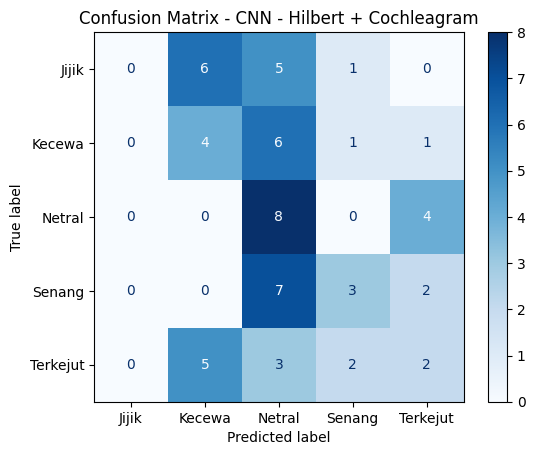

In [57]:
labels = enc.categories_[0]
cm = confusion_matrix(y_true_cnn_hilbert_cochleagram, y_pred_cnn_hilbert_cochleagram)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - CNN - Hilbert + Cochleagram')
plt.show()

### Akurasi, Precision, Recall, F1-score (Metrics CNN) Hilbert + Cochleagram

In [58]:
print("Akurasi :", accuracy_score(y_true_cnn_hilbert_cochleagram, y_pred_cnn_hilbert_cochleagram))
print("Precision (macro):", precision_score(y_true_cnn_hilbert_cochleagram, y_pred_cnn_hilbert_cochleagram, average='macro'))
print("Recall (macro):", recall_score(y_true_cnn_hilbert_cochleagram, y_pred_cnn_hilbert_cochleagram, average='macro'))
print("F1-score (macro):", f1_score(y_true_cnn_hilbert_cochleagram, y_pred_cnn_hilbert_cochleagram, average='macro'))
print("\nClassification Report:\n", classification_report(y_true_cnn_hilbert_cochleagram, y_pred_cnn_hilbert_cochleagram, target_names=labels))

Akurasi : 0.2833333333333333
Precision (macro): 0.23866447728516693
Recall (macro): 0.2833333333333333
F1-score (macro): 0.23856117257914433

Classification Report:
               precision    recall  f1-score   support

       Jijik       0.00      0.00      0.00        12
      Kecewa       0.27      0.33      0.30        12
      Netral       0.28      0.67      0.39        12
      Senang       0.43      0.25      0.32        12
    Terkejut       0.22      0.17      0.19        12

    accuracy                           0.28        60
   macro avg       0.24      0.28      0.24        60
weighted avg       0.24      0.28      0.24        60



### AUC-ROC CNN Hilbert + Cochleagram

In [59]:
auc_roc_cnn_hilbert_cochleagram = roc_auc_score(y_test_hilbert_cochleagram, y_pred_proba_cnn_hilbert_cochleagram, average='macro', multi_class='ovr')
print("AUC-ROC (macro, ovr) :", auc_roc_cnn_hilbert_cochleagram)

AUC-ROC (macro, ovr) : 0.65625


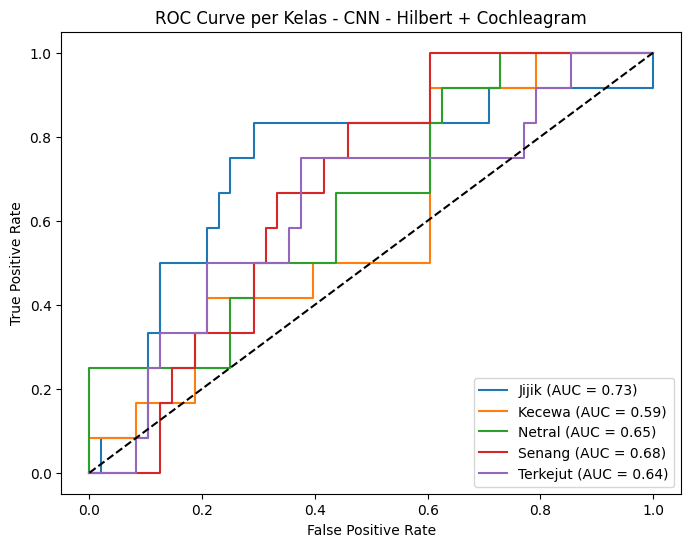

In [60]:
# ROC Curve per kelas
plt.figure(figsize=(8,6))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test_hilbert_cochleagram[:, i], y_pred_proba_cnn_hilbert_cochleagram[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Kelas - CNN - Hilbert + Cochleagram')
plt.legend()
plt.show()

## Model CNN Hybrid

In [33]:
# Split data
X_train_hybrid, X_test_hybrid, y_train_hybrid, y_test_hybrid = train_test_split(hybrid, y, test_size=0.2, random_state=42, stratify=y)

In [61]:
input_shape = (hybrid.shape[1], 1)

model_cnn_hybrid = Sequential([
    Conv1D(256, kernel_size=5, activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),                 
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')  # 5 kelas emosi
])

model_cnn_hybrid.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_hybrid.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 91, 256)           1536      
                                                                 
 batch_normalization_6 (Bat  (None, 91, 256)           1024      
 chNormalization)                                                
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 45, 256)           0         
 g1D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 45, 256)           0         
                                                                 
 conv1d_7 (Conv1D)           (None, 43, 128)           98432     
                                                                 
 batch_normalization_7 (Bat  (None, 43, 128)          

In [62]:
history_cnn_hybrid = model_cnn_hybrid.fit(X_train_hybrid, y_train_hybrid, validation_data=(X_test_hybrid, y_test_hybrid), epochs=50, batch_size=32)

Epoch 1/50
8/8 [==============================] - 16s 569ms/step - loss: 2.5412 - accuracy: 0.1500 - val_loss: 2.2655 - val_accuracy: 0.2000
Epoch 2/50
8/8 [==============================] - 3s 311ms/step - loss: 1.8773 - accuracy: 0.2208 - val_loss: 1.6976 - val_accuracy: 0.2000
Epoch 3/50
8/8 [==============================] - 2s 271ms/step - loss: 1.8183 - accuracy: 0.2000 - val_loss: 2.1207 - val_accuracy: 0.2000
Epoch 4/50
8/8 [==============================] - 2s 270ms/step - loss: 1.6958 - accuracy: 0.1833 - val_loss: 1.9351 - val_accuracy: 0.2000
Epoch 5/50
8/8 [==============================] - 2s 284ms/step - loss: 1.6578 - accuracy: 0.2292 - val_loss: 1.7168 - val_accuracy: 0.2000
Epoch 6/50
8/8 [==============================] - 2s 276ms/step - loss: 1.6522 - accuracy: 0.2292 - val_loss: 1.6484 - val_accuracy: 0.1667
Epoch 7/50
8/8 [==============================] - 2s 280ms/step - loss: 1.6178 - accuracy: 0.2167 - val_loss: 1.6885 - val_accuracy: 0.2000
Epoch 8/50
8/8 [===

In [ ]:
# Simpan model yang telah dilatih
model_cnn_hybrid.save('dataset/model_CNN_hybrid_experimental.h5')

# Simpan label encoder ke file
## np.save('Dataset/label_encoder.npy', label_encoder.classes_)
## np.save('dataset/label_encoder_CNN.npy', enc.categories_[0])

## Kurva Loss dan Akurasi CNN Hybrid

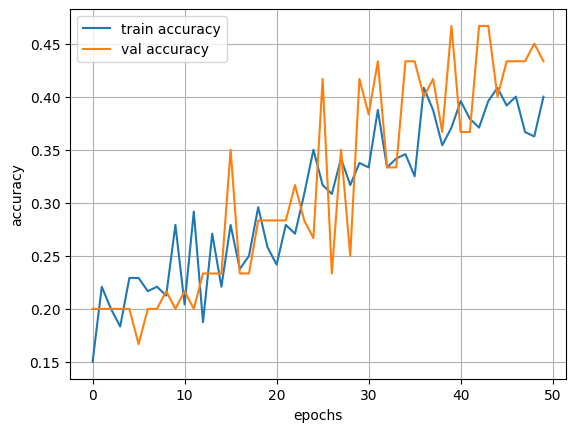

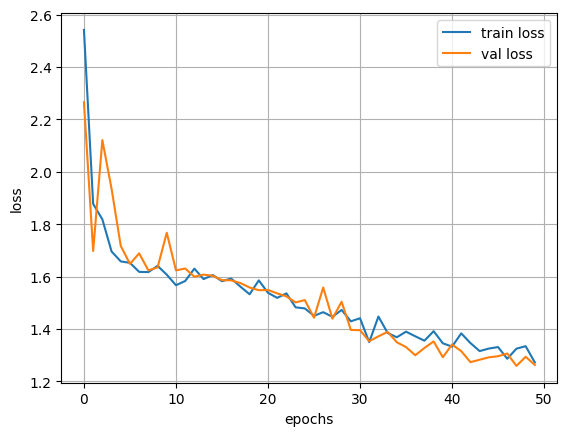

In [63]:
epochs = list(range(len(history_cnn_hybrid.history['accuracy'])))
plt.plot(epochs, history_cnn_hybrid.history['accuracy'], label='train accuracy')
plt.plot(epochs, history_cnn_hybrid.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(epochs, history_cnn_hybrid.history['loss'], label='train loss')
plt.plot(epochs, history_cnn_hybrid.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.show()

## Evaluasi CNN Hybrid

In [64]:
# Prediksi
y_pred_proba_cnn_hybrid = model_cnn_hybrid.predict(X_test_hybrid)
y_pred_cnn_hybrid = np.argmax(y_pred_proba_cnn_hybrid, axis=1)
y_true_cnn_hybrid = np.argmax(y_test_hybrid, axis=1)

2/2 [==============================] - 5s 84ms/step


### Confusion Matrix CNN Hybrid

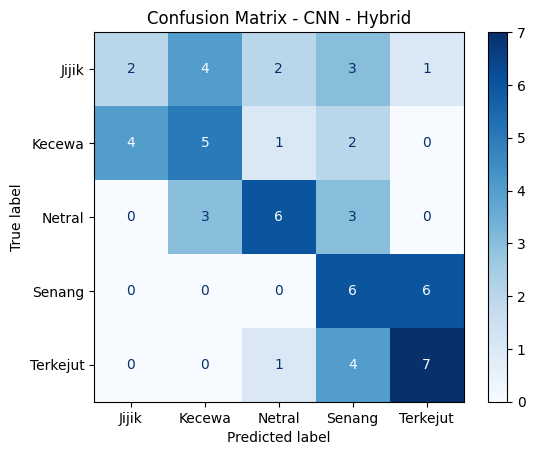

In [65]:
labels = enc.categories_[0]
cm = confusion_matrix(y_true_cnn_hybrid, y_pred_cnn_hybrid)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - CNN - Hybrid')
plt.show()

### Akurasi, Precision, Recall, F1-score (Metrics CNN) Hybrid

In [66]:
print("Akurasi CNN:", accuracy_score(y_true_cnn_hybrid, y_pred_cnn_hybrid))
print("Precision (macro):", precision_score(y_true_cnn_hybrid, y_pred_cnn_hybrid, average='macro'))
print("Recall (macro):", recall_score(y_true_cnn_hybrid, y_pred_cnn_hybrid, average='macro'))
print("F1-score (macro):", f1_score(y_true_cnn_hybrid, y_pred_cnn_hybrid, average='macro'))
print("\nClassification Report:\n", classification_report(y_true_cnn_hybrid, y_pred_cnn_hybrid, target_names=labels))

Akurasi CNN: 0.43333333333333335
Precision (macro): 0.4366666666666667
Recall (macro): 0.4333333333333334
F1-score (macro): 0.4245609945609945

Classification Report:
               precision    recall  f1-score   support

       Jijik       0.33      0.17      0.22        12
      Kecewa       0.42      0.42      0.42        12
      Netral       0.60      0.50      0.55        12
      Senang       0.33      0.50      0.40        12
    Terkejut       0.50      0.58      0.54        12

    accuracy                           0.43        60
   macro avg       0.44      0.43      0.42        60
weighted avg       0.44      0.43      0.42        60



### AUC-ROC CNN Hybrid

In [67]:
auc_roc_cnn_hybrid = roc_auc_score(y_test_hybrid, y_pred_proba_cnn_hybrid, average='macro', multi_class='ovr')
print("AUC-ROC (macro, ovr) CNN:", auc_roc_cnn_hybrid)

AUC-ROC (macro, ovr) CNN: 0.7989583333333333


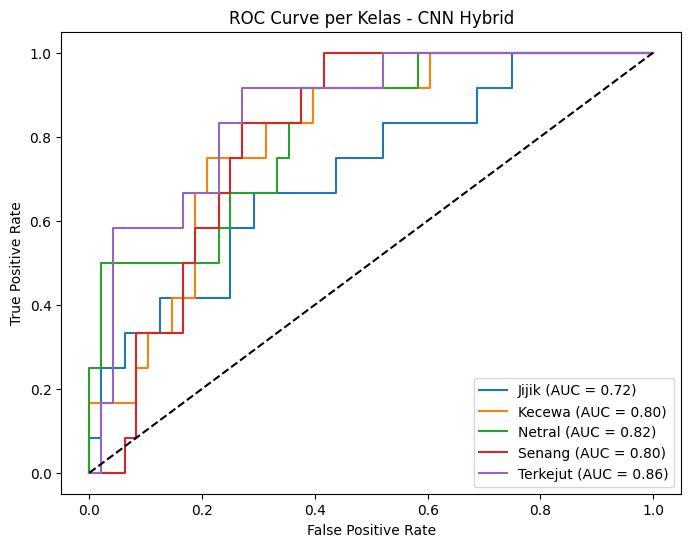

In [68]:
# ROC Curve per kelas
plt.figure(figsize=(8,6))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test_hybrid[:, i], y_pred_proba_cnn_hybrid[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Kelas - CNN Hybrid')
plt.legend()
plt.show()

## Model LSTM - MFCC + Hilbert

In [69]:
input_shape = (mfcc_hilbert.shape[1], 1)

model_lstm_mfcc_hilbert = Sequential([
    LSTM(256, return_sequences=False, input_shape=input_shape),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(5, activation='softmax')
])

model_lstm_mfcc_hilbert.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm_mfcc_hilbert.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dropout_16 (Dropout)        (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 5)                

In [70]:
# Training
history_lstm_mfcc_hilbert = model_lstm_mfcc_hilbert.fit(X_train_mfcc_hilbert, y_train_mfcc_hilbert, validation_data=(X_test_mfcc_hilbert, y_test_mfcc_hilbert), epochs=50, batch_size=32)

Epoch 1/50
8/8 [==============================] - 115s 5s/step - loss: 1.8039 - accuracy: 0.2125 - val_loss: 1.6268 - val_accuracy: 0.2000
Epoch 2/50
8/8 [==============================] - 18s 2s/step - loss: 1.7000 - accuracy: 0.2208 - val_loss: 1.6170 - val_accuracy: 0.2000
Epoch 3/50
8/8 [==============================] - 17s 2s/step - loss: 1.7358 - accuracy: 0.1458 - val_loss: 1.6064 - val_accuracy: 0.2167
Epoch 4/50
8/8 [==============================] - 12s 2s/step - loss: 1.6507 - accuracy: 0.2292 - val_loss: 1.6094 - val_accuracy: 0.1833
Epoch 5/50
8/8 [==============================] - 16s 2s/step - loss: 1.6605 - accuracy: 0.1833 - val_loss: 1.6114 - val_accuracy: 0.2167
Epoch 6/50
8/8 [==============================] - 8s 1s/step - loss: 1.6565 - accuracy: 0.1917 - val_loss: 1.6109 - val_accuracy: 0.2000
Epoch 7/50
8/8 [==============================] - 10s 1s/step - loss: 1.6504 - accuracy: 0.1792 - val_loss: 1.6113 - val_accuracy: 0.2167
Epoch 8/50
8/8 [==================

In [ ]:
# Simpan model yang telah dilatih
model_lstm_mfcc_hilbert.save('dataset/model_LSTM_mfcc_hilbert.h5')

# Simpan label encoder ke file
## np.save('Dataset/label_encoder.npy', label_encoder.classes_)
# np.save('dataset/label_encoder_LSTM.npy', enc.categories_[0])

## Kurva Loss dan Akurasi LSTM - MFCC + Hilbert

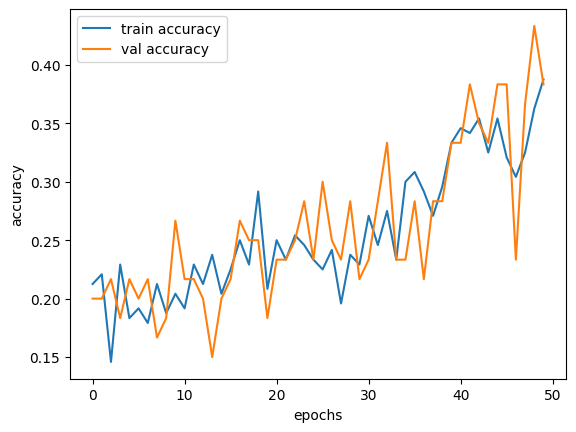

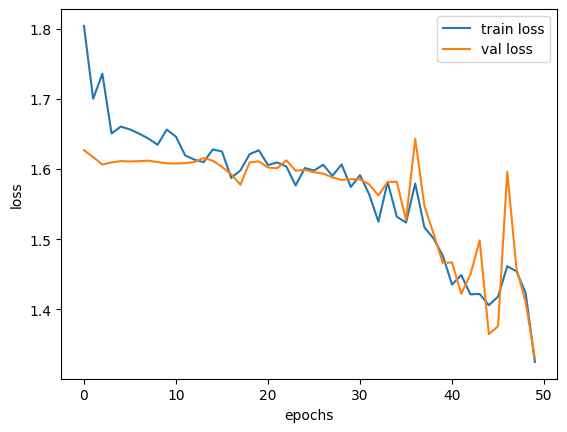

In [71]:
epochs = list(range(len(history_lstm_mfcc_hilbert.history['accuracy'])))
plt.plot(epochs, history_lstm_mfcc_hilbert.history['accuracy'], label='train accuracy')
plt.plot(epochs, history_lstm_mfcc_hilbert.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.plot(epochs, history_lstm_mfcc_hilbert.history['loss'], label='train loss')
plt.plot(epochs, history_lstm_mfcc_hilbert.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## Evaluasi LSTM - MFCC + Hilbert

In [72]:
# Prediksi
y_pred_proba_lstm_mfcc_hilbert = model_lstm_mfcc_hilbert.predict(X_test_mfcc_hilbert)
y_pred_lstm_mfcc_hilbert = np.argmax(y_pred_proba_lstm_mfcc_hilbert, axis=1)
y_true_lstm_mfcc_hilbert = np.argmax(y_test_mfcc_hilbert, axis=1)

2/2 [==============================] - 5s 532ms/step


### Confusion Matrix LSTM - MFCC + LSTM

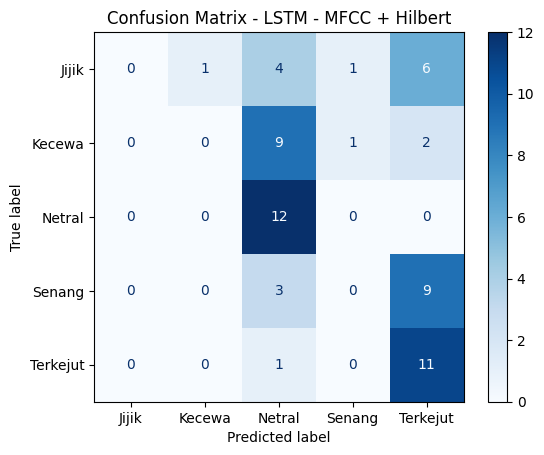

In [73]:
cm = confusion_matrix(y_true_lstm_mfcc_hilbert, y_pred_lstm_mfcc_hilbert)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - LSTM - MFCC + Hilbert')
plt.show()

### Akurasi, Precision, Recall, F1-score (Metrics LSTM) MFCC + Hilbert

In [74]:
print("Akurasi :", accuracy_score(y_true_lstm_mfcc_hilbert, y_pred_lstm_mfcc_hilbert))
print("Precision (macro):", precision_score(y_true_lstm_mfcc_hilbert, y_pred_lstm_mfcc_hilbert, average='macro'))
print("Recall (macro):", recall_score(y_true_lstm_mfcc_hilbert, y_pred_lstm_mfcc_hilbert, average='macro'))
print("F1-score (macro):", f1_score(y_true_lstm_mfcc_hilbert, y_pred_lstm_mfcc_hilbert, average='macro'))
print("\nClassification Report:\n", classification_report(y_true_lstm_mfcc_hilbert, y_pred_lstm_mfcc_hilbert, target_names=labels))

Akurasi : 0.38333333333333336
Precision (macro): 0.16133004926108374
Recall (macro): 0.3833333333333333
F1-score (macro): 0.2270731707317073

Classification Report:
               precision    recall  f1-score   support

       Jijik       0.00      0.00      0.00        12
      Kecewa       0.00      0.00      0.00        12
      Netral       0.41      1.00      0.59        12
      Senang       0.00      0.00      0.00        12
    Terkejut       0.39      0.92      0.55        12

    accuracy                           0.38        60
   macro avg       0.16      0.38      0.23        60
weighted avg       0.16      0.38      0.23        60



### AUC-ROC LSTM - MFCC + Hilbert

In [75]:
auc_roc_lstm_mfcc_hilbert = roc_auc_score(y_test_mfcc_hilbert, y_pred_proba_lstm_mfcc_hilbert, average='macro', multi_class='ovr')
print("AUC-ROC (macro, ovr) LSTM:", auc_roc_lstm_mfcc_hilbert)

AUC-ROC (macro, ovr) LSTM: 0.7465277777777778


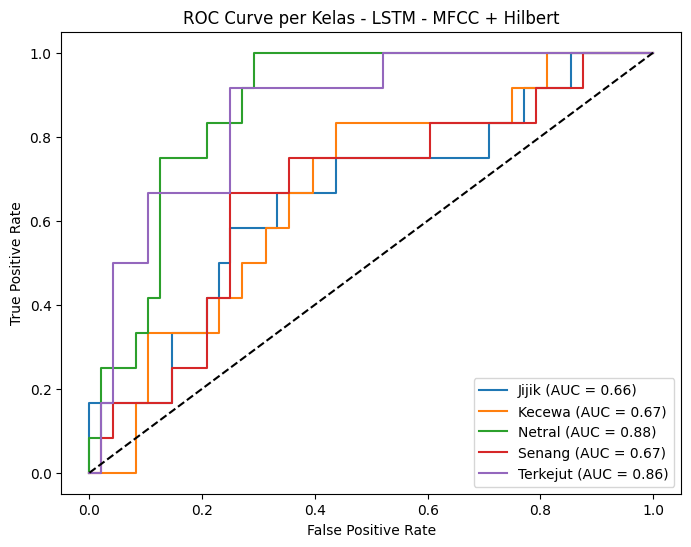

In [76]:
# ROC Curve per kelas
plt.figure(figsize=(8,6))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test_mfcc_hilbert[:, i], y_pred_proba_lstm_mfcc_hilbert[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Kelas - LSTM - MFCC + Hilbert')
plt.legend()
plt.show()

## Model LSTM - MFCC + Cochleagram

In [77]:
input_shape = (mfcc_cochleagram.shape[1], 1)

model_lstm_mfcc_cochleagram = Sequential([
    LSTM(128, return_sequences=False, input_shape=input_shape),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(5, activation='softmax')
])


model_lstm_mfcc_cochleagram.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm_mfcc_cochleagram.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_19 (Dropout)        (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dropout_21 (Dropout)        (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 5)                

In [78]:
# Training
history_lstm_mfcc_cochleagram = model_lstm_mfcc_cochleagram.fit(X_train_mfcc_cochleagram, y_train_mfcc_cochleagram, validation_data=(X_test_mfcc_cochleagram, y_test_mfcc_cochleagram), epochs=50, batch_size=64)

Epoch 1/50
4/4 [==============================] - 24s 2s/step - loss: 1.6099 - accuracy: 0.1875 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 2/50
4/4 [==============================] - 2s 590ms/step - loss: 1.6098 - accuracy: 0.1625 - val_loss: 1.6097 - val_accuracy: 0.2000
Epoch 3/50
4/4 [==============================] - 2s 589ms/step - loss: 1.6082 - accuracy: 0.1875 - val_loss: 1.6125 - val_accuracy: 0.1000
Epoch 4/50
4/4 [==============================] - 2s 597ms/step - loss: 1.6034 - accuracy: 0.2500 - val_loss: 1.6256 - val_accuracy: 0.1167
Epoch 5/50
4/4 [==============================] - 2s 589ms/step - loss: 1.6031 - accuracy: 0.2250 - val_loss: 1.6073 - val_accuracy: 0.2333
Epoch 6/50
4/4 [==============================] - 2s 587ms/step - loss: 1.5933 - accuracy: 0.2583 - val_loss: 1.6207 - val_accuracy: 0.1167
Epoch 7/50
4/4 [==============================] - 2s 576ms/step - loss: 1.5758 - accuracy: 0.2375 - val_loss: 1.5950 - val_accuracy: 0.2333
Epoch 8/50
4/4 [======

In [ ]:
# Simpan model yang telah dilatih
model_lstm_mfcc_cochleagram.save('dataset/model_LSTM_mfcc_cochleagram.h5')

# Simpan label encoder ke file
## np.save('Dataset/label_encoder.npy', label_encoder.classes_)
# np.save('dataset/label_encoder_LSTM.npy', enc.categories_[0])

## Kurva Loss dan Akurasi LSTM - MFCC + Cochleagram

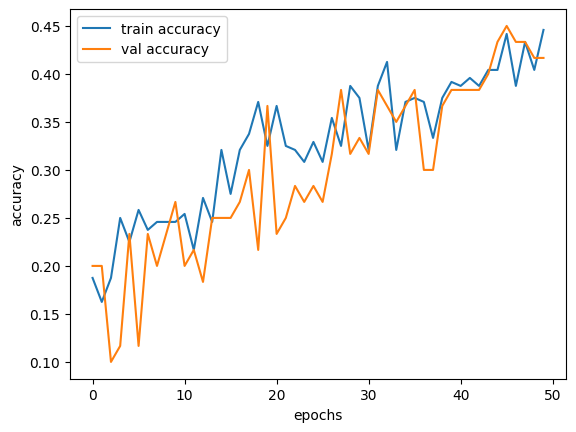

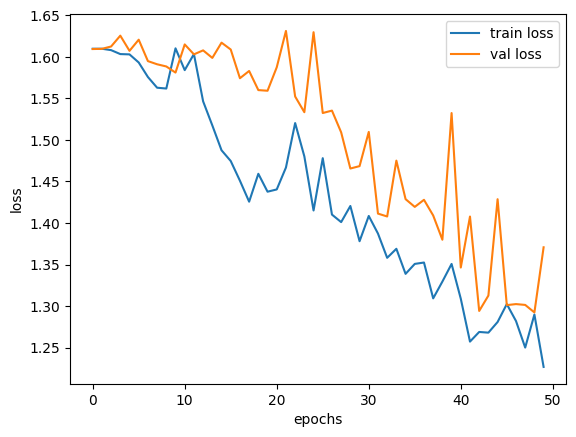

In [79]:
epochs = list(range(len(history_lstm_mfcc_cochleagram.history['accuracy'])))
plt.plot(epochs, history_lstm_mfcc_cochleagram.history['accuracy'], label='train accuracy')
plt.plot(epochs, history_lstm_mfcc_cochleagram.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.plot(epochs, history_lstm_mfcc_cochleagram.history['loss'], label='train loss')
plt.plot(epochs, history_lstm_mfcc_cochleagram.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## Evaluasi LSTM - MFCC + Cochleagram

In [80]:
# Prediksi
y_pred_proba_lstm_mfcc_cochleagram = model_lstm_mfcc_cochleagram.predict(X_test_mfcc_cochleagram)
y_pred_lstm_mfcc_cochleagram = np.argmax(y_pred_proba_lstm_mfcc_cochleagram, axis=1)
y_true_lstm_mfcc_cochleagram = np.argmax(y_test_mfcc_cochleagram, axis=1)

2/2 [==============================] - 4s 389ms/step


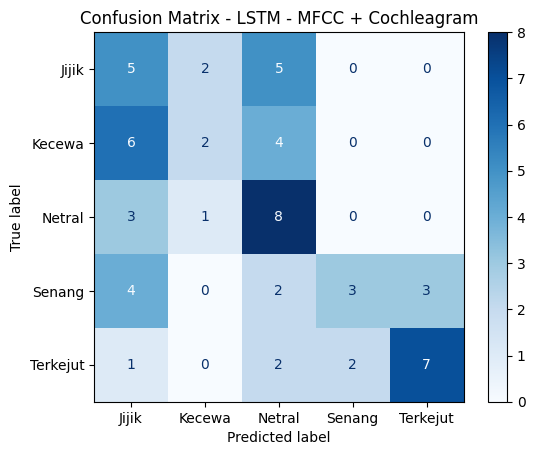

In [81]:
cm = confusion_matrix(y_true_lstm_mfcc_cochleagram, y_pred_lstm_mfcc_cochleagram)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - LSTM - MFCC + Cochleagram')
plt.show()

### Akurasi, Precision, Recall, F1-score (Metrics LSTM) MFCC + Cochleagram

In [82]:
print("Akurasi :", accuracy_score(y_true_lstm_mfcc_cochleagram, y_pred_lstm_mfcc_cochleagram))
print("Precision (macro):", precision_score(y_true_lstm_mfcc_cochleagram, y_pred_lstm_mfcc_cochleagram, average='macro'))
print("Recall (macro):", recall_score(y_true_lstm_mfcc_cochleagram, y_pred_lstm_mfcc_cochleagram, average='macro'))
print("F1-score (macro):", f1_score(y_true_lstm_mfcc_cochleagram, y_pred_lstm_mfcc_cochleagram, average='macro'))
print("\nClassification Report:\n", classification_report(y_true_lstm_mfcc_cochleagram, y_pred_lstm_mfcc_cochleagram, target_names=labels))

Akurasi : 0.4166666666666667
Precision (macro): 0.46882205513784464
Recall (macro): 0.4166666666666667
F1-score (macro): 0.40640561209821174

Classification Report:
               precision    recall  f1-score   support

       Jijik       0.26      0.42      0.32        12
      Kecewa       0.40      0.17      0.24        12
      Netral       0.38      0.67      0.48        12
      Senang       0.60      0.25      0.35        12
    Terkejut       0.70      0.58      0.64        12

    accuracy                           0.42        60
   macro avg       0.47      0.42      0.41        60
weighted avg       0.47      0.42      0.41        60



### AUC-ROC LSTM - MFCC + Cochleagram

In [83]:
auc_roc_lstm_mfcc_cochleagram = roc_auc_score(y_test_mfcc_cochleagram, y_pred_proba_lstm_mfcc_cochleagram, average='macro', multi_class='ovr')
print("AUC-ROC (macro, ovr) :", auc_roc_lstm_mfcc_cochleagram)

AUC-ROC (macro, ovr) : 0.7083333333333333


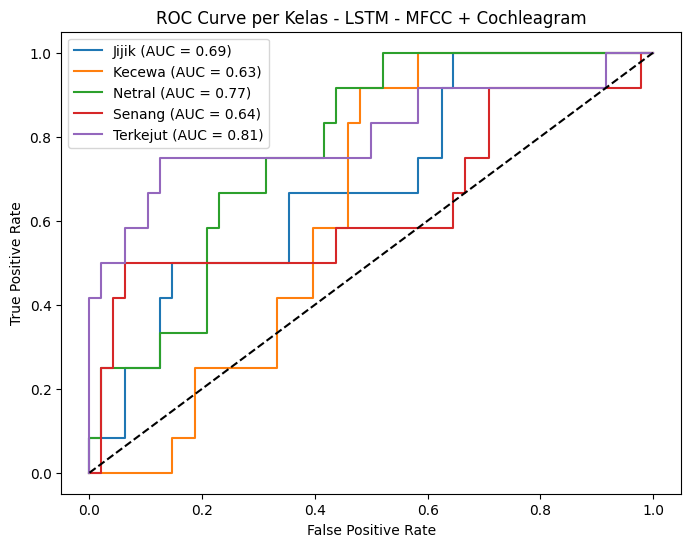

In [84]:
# ROC Curve per kelas
plt.figure(figsize=(8,6))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test_mfcc_cochleagram[:, i], y_pred_proba_lstm_mfcc_cochleagram[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Kelas - LSTM - MFCC + Cochleagram')
plt.legend()
plt.show()

## Model LSTM - Hilbert + Cochleagram

In [85]:
input_shape = (hilbert_cochleagram.shape[1], 1)

model_lstm_hilbert_cochleagram = Sequential([
    LSTM(128, return_sequences=False, input_shape=input_shape),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(5, activation='softmax')
])


model_lstm_hilbert_cochleagram.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm_hilbert_cochleagram.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_22 (Dropout)        (None, 128)               0         
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dropout_23 (Dropout)        (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 dropout_24 (Dropout)        (None, 32)                0         
                                                                 
 dense_20 (Dense)            (None, 5)                

In [86]:
# Training
history_lstm_hilbert_cochleagram = model_lstm_hilbert_cochleagram.fit(X_train_hilbert_cochleagram, y_train_hilbert_cochleagram, validation_data=(X_test_hilbert_cochleagram, y_test_hilbert_cochleagram), epochs=50, batch_size=32)

Epoch 1/50
8/8 [==============================] - 33s 1s/step - loss: 1.6103 - accuracy: 0.1792 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 2/50
8/8 [==============================] - 3s 378ms/step - loss: 1.6102 - accuracy: 0.1917 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 3/50
8/8 [==============================] - 3s 350ms/step - loss: 1.6101 - accuracy: 0.1750 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 4/50
8/8 [==============================] - 4s 477ms/step - loss: 1.6096 - accuracy: 0.2208 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 5/50
8/8 [==============================] - 3s 348ms/step - loss: 1.6096 - accuracy: 0.2167 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 6/50
8/8 [==============================] - 3s 346ms/step - loss: 1.6098 - accuracy: 0.2167 - val_loss: 1.6094 - val_accuracy: 0.2000
Epoch 7/50
8/8 [==============================] - 3s 343ms/step - loss: 1.6096 - accuracy: 0.2000 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 8/50
8/8 [======

In [ ]:
# Simpan model yang telah dilatih
model_lstm_hilbert_cochleagram.save('dataset/model_LSTM_hilbert_cochleagram.h5')

# Simpan label encoder ke file
## np.save('Dataset/label_encoder.npy', label_encoder.classes_)
# np.save('dataset/label_encoder_LSTM.npy', enc.categories_[0])

## Kurva Loss dan Akurasi LSTM - Hilbert + Cochleagram

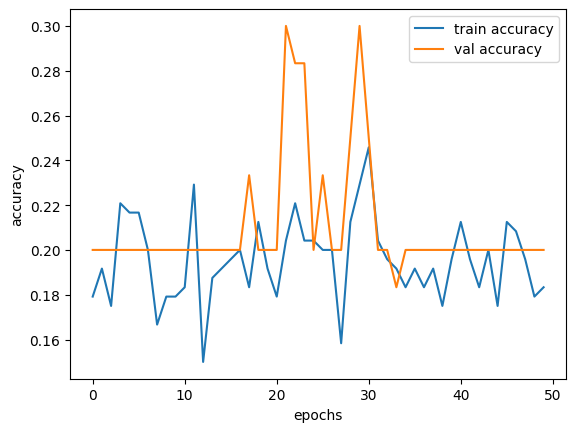

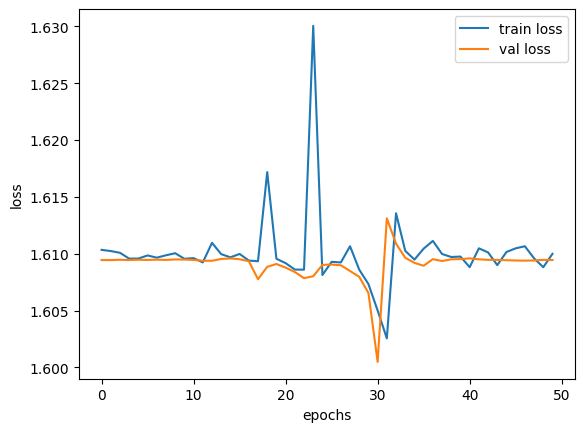

In [87]:
epochs = list(range(len(history_lstm_hilbert_cochleagram.history['accuracy'])))
plt.plot(epochs, history_lstm_hilbert_cochleagram.history['accuracy'], label='train accuracy')
plt.plot(epochs, history_lstm_hilbert_cochleagram.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.plot(epochs, history_lstm_hilbert_cochleagram.history['loss'], label='train loss')
plt.plot(epochs, history_lstm_hilbert_cochleagram.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## Evaluasi LSTM - Hilbert + Cochleagram

In [88]:
# Prediksi
y_pred_proba_lstm_hilbert_cochleagram = model_lstm_hilbert_cochleagram.predict(X_test_hilbert_cochleagram)
y_pred_lstm_hilbert_cochleagram = np.argmax(y_pred_proba_lstm_hilbert_cochleagram, axis=1)
y_true_lstm_hilbert_cochleagram = np.argmax(y_test_hilbert_cochleagram, axis=1)

2/2 [==============================] - 3s 91ms/step


## Confusion Matrix LSTM - Hilbert + Cochleagram

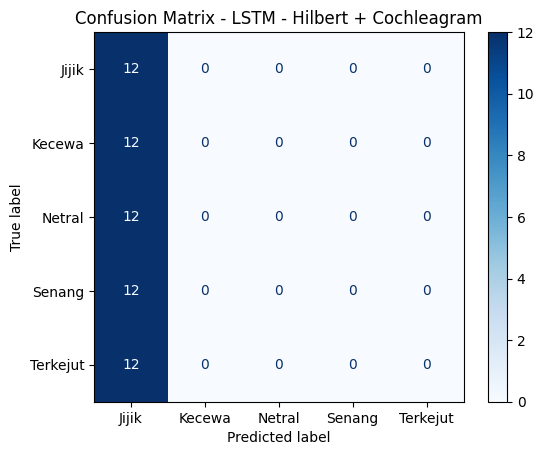

In [89]:
cm = confusion_matrix(y_true_lstm_hilbert_cochleagram, y_pred_lstm_hilbert_cochleagram)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - LSTM - Hilbert + Cochleagram')
plt.show()

### Akurasi, Precision, Recall, F1-score (Metrics LSTM) Hilbert + Cochleagram

In [90]:
print("Akurasi :", accuracy_score(y_true_lstm_hilbert_cochleagram, y_pred_lstm_hilbert_cochleagram))
print("Precision (macro):", precision_score(y_true_lstm_hilbert_cochleagram, y_pred_lstm_hilbert_cochleagram, average='macro'))
print("Recall (macro):", recall_score(y_true_lstm_hilbert_cochleagram, y_pred_lstm_hilbert_cochleagram, average='macro'))
print("F1-score (macro):", f1_score(y_true_lstm_hilbert_cochleagram, y_pred_lstm_hilbert_cochleagram, average='macro'))
print("\nClassification Report:\n", classification_report(y_true_lstm_hilbert_cochleagram, y_pred_lstm_hilbert_cochleagram, target_names=labels))

Akurasi : 0.2
Precision (macro): 0.04
Recall (macro): 0.2
F1-score (macro): 0.06666666666666668

Classification Report:
               precision    recall  f1-score   support

       Jijik       0.20      1.00      0.33        12
      Kecewa       0.00      0.00      0.00        12
      Netral       0.00      0.00      0.00        12
      Senang       0.00      0.00      0.00        12
    Terkejut       0.00      0.00      0.00        12

    accuracy                           0.20        60
   macro avg       0.04      0.20      0.07        60
weighted avg       0.04      0.20      0.07        60



### AUC-ROC LSTM - Hilbert + Cochleagram

In [91]:
auc_roc_lstm_hilbert_cochleagram = roc_auc_score(y_test_hilbert_cochleagram, y_pred_proba_lstm_hilbert_cochleagram, average='macro', multi_class='ovr')
print("AUC-ROC (macro, ovr) :", auc_roc_lstm_hilbert_cochleagram)

AUC-ROC (macro, ovr) : 0.7085069444444445


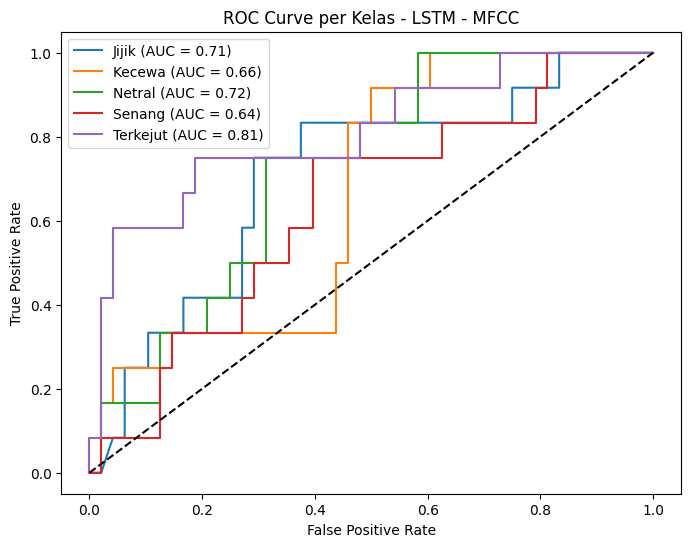

In [92]:
# ROC Curve per kelas
plt.figure(figsize=(8,6))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test_hilbert_cochleagram[:, i], y_pred_proba_lstm_hilbert_cochleagram[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Kelas - LSTM - MFCC')
plt.legend()
plt.show()

## Model LSTM Hybrid

In [93]:
input_shape = (hybrid.shape[1], 1)

model_lstm_hybrid = Sequential([
    LSTM(256, return_sequences=False, input_shape=input_shape),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model_lstm_hybrid.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm_hybrid.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 256)               264192    
                                                                 
 dropout_25 (Dropout)        (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 128)               32896     
                                                                 
 dropout_26 (Dropout)        (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 dropout_27 (Dropout)        (None, 64)                0         
                                                                 
 dense_23 (Dense)            (None, 5)                

In [94]:
# Training
history_lstm_hybrid = model_lstm_hybrid.fit(X_train_hybrid, y_train_hybrid, validation_data=(X_test_hybrid, y_test_hybrid), epochs=50, batch_size=32)

Epoch 1/50
8/8 [==============================] - 36s 3s/step - loss: 1.6107 - accuracy: 0.1417 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 2/50
8/8 [==============================] - 20s 3s/step - loss: 1.6115 - accuracy: 0.1625 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 3/50
8/8 [==============================] - 20s 2s/step - loss: 1.6089 - accuracy: 0.1542 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 4/50
8/8 [==============================] - 21s 3s/step - loss: 1.6101 - accuracy: 0.2042 - val_loss: 1.6096 - val_accuracy: 0.2000
Epoch 5/50
8/8 [==============================] - 19s 2s/step - loss: 1.6109 - accuracy: 0.1792 - val_loss: 1.6096 - val_accuracy: 0.2000
Epoch 6/50
8/8 [==============================] - 19s 2s/step - loss: 1.6090 - accuracy: 0.2208 - val_loss: 1.6098 - val_accuracy: 0.2000
Epoch 7/50
8/8 [==============================] - 20s 3s/step - loss: 1.6116 - accuracy: 0.2250 - val_loss: 1.6097 - val_accuracy: 0.2000
Epoch 8/50
8/8 [==================

In [ ]:
# Simpan model yang telah dilatih
model_lstm_hybrid.save('dataset/model_LSTM_hybrid_experimental.h5')

# Simpan label encoder ke file
## np.save('Dataset/label_encoder.npy', label_encoder.classes_)
# np.save('dataset/label_encoder_LSTM.npy', enc.categories_[0])

## Kurva Loss dan Akurasi LSTM - Hybrid

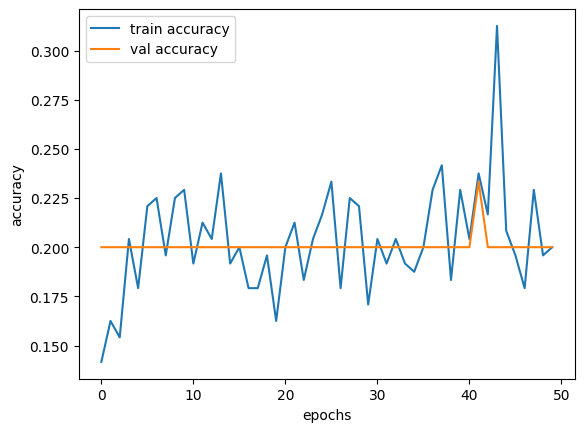

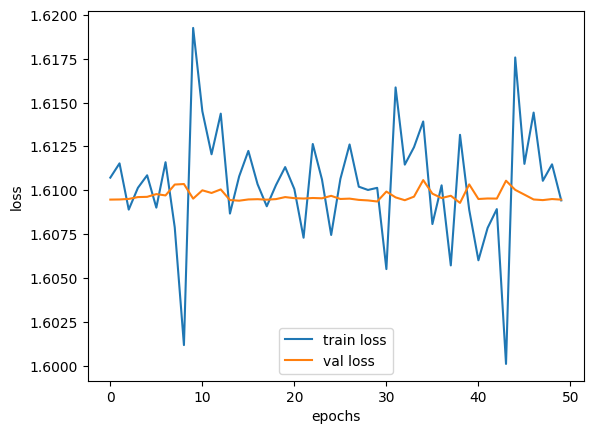

In [95]:
epochs = list(range(len(history_lstm_hybrid.history['accuracy'])))
plt.plot(epochs, history_lstm_hybrid.history['accuracy'], label='train accuracy')
plt.plot(epochs, history_lstm_hybrid.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.plot(epochs, history_lstm_hybrid.history['loss'], label='train loss')
plt.plot(epochs, history_lstm_hybrid.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## Evaluasi LSTM - Hybrid

In [96]:
# Prediksi
y_pred_proba_lstm_hybrid = model_lstm_hybrid.predict(X_test_hybrid)
y_pred_lstm_hybrid = np.argmax(y_pred_proba_lstm_hybrid, axis=1)
y_true_lstm_hybrid = np.argmax(y_test_hybrid, axis=1)

2/2 [==============================] - 5s 876ms/step


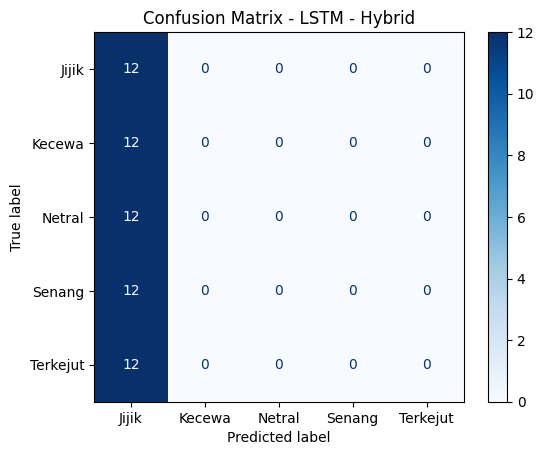

In [97]:
cm = confusion_matrix(y_true_lstm_hybrid, y_pred_lstm_hybrid)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - LSTM - Hybrid')
plt.show()

### Akurasi, Precision, Recall, F1-score (Metrics LSTM) Hybrid

In [98]:
print("Akurasi :", accuracy_score(y_true_lstm_hybrid, y_pred_lstm_hybrid))
print("Precision (macro):", precision_score(y_true_lstm_hybrid, y_pred_lstm_hybrid, average='macro'))
print("Recall (macro):", recall_score(y_true_lstm_hybrid, y_pred_lstm_hybrid, average='macro'))
print("F1-score (macro):", f1_score(y_true_lstm_hybrid, y_pred_lstm_hybrid, average='macro'))
print("\nClassification Report:\n", classification_report(y_true_lstm_hybrid, y_pred_lstm_hybrid, target_names=labels))

Akurasi : 0.2
Precision (macro): 0.04
Recall (macro): 0.2
F1-score (macro): 0.06666666666666668

Classification Report:
               precision    recall  f1-score   support

       Jijik       0.20      1.00      0.33        12
      Kecewa       0.00      0.00      0.00        12
      Netral       0.00      0.00      0.00        12
      Senang       0.00      0.00      0.00        12
    Terkejut       0.00      0.00      0.00        12

    accuracy                           0.20        60
   macro avg       0.04      0.20      0.07        60
weighted avg       0.04      0.20      0.07        60



### AUC-ROC LSTM - Hybrid

In [99]:
auc_roc_lstm_hybrid = roc_auc_score(y_test_hybrid, y_pred_proba_lstm_hybrid, average='macro', multi_class='ovr')
print("AUC-ROC (macro, ovr) :", auc_roc_lstm_hybrid)

AUC-ROC (macro, ovr) : 0.6532986111111111


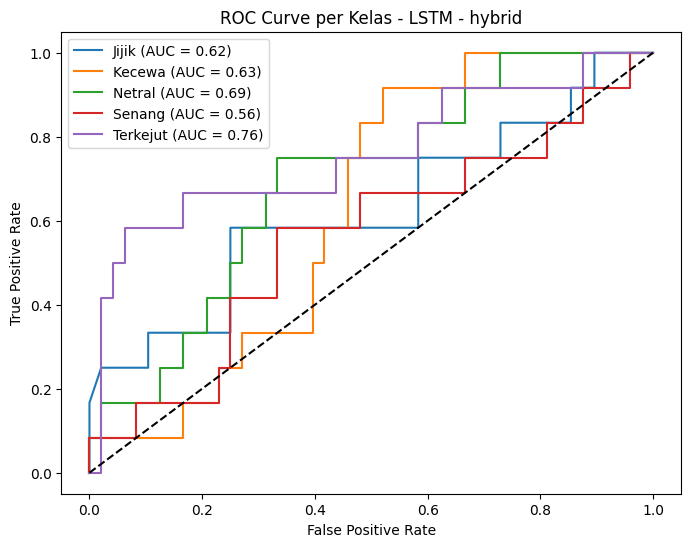

In [100]:
# ROC Curve per kelas
plt.figure(figsize=(8,6))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test_hybrid[:, i], y_pred_proba_lstm_hybrid[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Kelas - LSTM - hybrid')
plt.legend()
plt.show()

## Model CNN + LSTM

In [101]:
input_shape = (hybrid.shape[1], 1)

model_hybrid = Sequential([
    Conv1D(128, kernel_size=3, activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    LSTM(256, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')  # 5 kelas emosi
])

model_hybrid.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_hybrid.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 93, 128)           512       
                                                                 
 batch_normalization_8 (Bat  (None, 93, 128)           512       
 chNormalization)                                                
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 46, 128)           0         
 g1D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 46, 128)           0         
                                                                 
 conv1d_9 (Conv1D)           (None, 44, 64)            24640     
                                                                 
 batch_normalization_9 (Bat  (None, 44, 64)           

In [102]:
history_hybrid = model_hybrid.fit(X_train_hybrid, y_train_hybrid, validation_data=(X_test_hybrid, y_test_hybrid), epochs=50, batch_size=32)

Epoch 1/50
8/8 [==============================] - 27s 982ms/step - loss: 1.6204 - accuracy: 0.1833 - val_loss: 1.6323 - val_accuracy: 0.2000
Epoch 2/50
8/8 [==============================] - 4s 481ms/step - loss: 1.6255 - accuracy: 0.1833 - val_loss: 1.6415 - val_accuracy: 0.2000
Epoch 3/50
8/8 [==============================] - 4s 468ms/step - loss: 1.6256 - accuracy: 0.1833 - val_loss: 1.6438 - val_accuracy: 0.2000
Epoch 4/50
8/8 [==============================] - 4s 501ms/step - loss: 1.6053 - accuracy: 0.1708 - val_loss: 1.6451 - val_accuracy: 0.2000
Epoch 5/50
8/8 [==============================] - 4s 480ms/step - loss: 1.5937 - accuracy: 0.2625 - val_loss: 1.6713 - val_accuracy: 0.2000
Epoch 6/50
8/8 [==============================] - 4s 505ms/step - loss: 1.5699 - accuracy: 0.2917 - val_loss: 1.9071 - val_accuracy: 0.2000
Epoch 7/50
8/8 [==============================] - 4s 499ms/step - loss: 1.5522 - accuracy: 0.2917 - val_loss: 1.9734 - val_accuracy: 0.2000
Epoch 8/50
8/8 [===

In [ ]:
# Simpan model yang telah dilatih
model_hybrid.save('dataset/model_hybrid_experimental.h5')

# Simpan label encoder ke file
## np.save('Dataset/label_encoder.npy', label_encoder.classes_)
## np.save('dataset/label_encoder_hybrid.npy', enc.categories_[0])

## Kurva Loss dan Akurasi CNN + LSTM

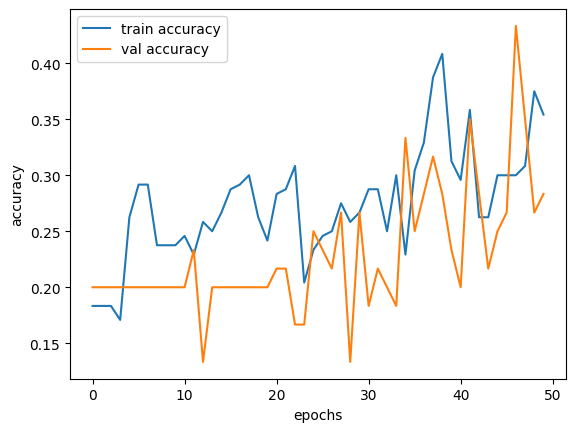

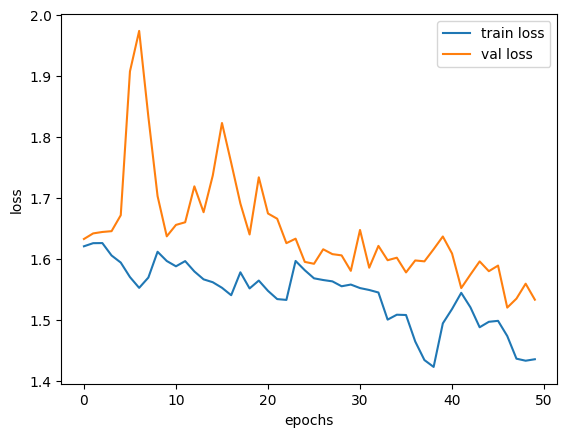

In [103]:
epochs = list(range(len(history_hybrid.history['accuracy'])))
plt.plot(epochs, history_hybrid.history['accuracy'], label='train accuracy')
plt.plot(epochs, history_hybrid.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.plot(epochs, history_hybrid.history['loss'], label='train loss')
plt.plot(epochs, history_hybrid.history['val_loss'], label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## Evaluasi CNN + LSTM

In [104]:
# Prediksi probabilitas
y_pred_proba_hybrid = model_hybrid.predict(X_test_hybrid)
# Prediksi kelas
y_pred_hybrid = np.argmax(y_pred_proba_hybrid, axis=1)
y_true_hybrid = np.argmax(y_test_hybrid, axis=1)

2/2 [==============================] - 3s 142ms/step


### Confusion Matrix CNN + LSTM

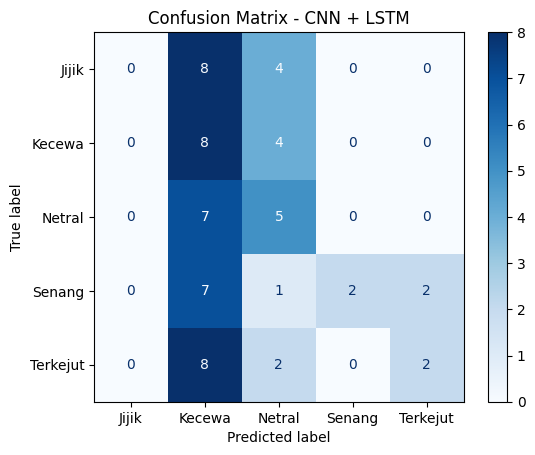

In [105]:
cm = confusion_matrix(y_true_hybrid, y_pred_hybrid)
labels = enc.categories_[0]  # Label emosi IndoWaveSentiment
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - CNN + LSTM')
plt.show()

### Akurasi, Precision, Recall, F1-score (Metrics) CNN + LSTM

In [106]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

print("Akurasi:", accuracy_score(y_true_hybrid, y_pred_hybrid))
print("Precision (macro):", precision_score(y_true_hybrid, y_pred_hybrid, average='macro'))
print("Recall (macro):", recall_score(y_true_hybrid, y_pred_hybrid, average='macro'))
print("F1-score (macro):", f1_score(y_true_hybrid, y_pred_hybrid, average='macro'))
print("\nClassification Report:\n", classification_report(y_true_hybrid, y_pred_hybrid, target_names=labels))

Akurasi: 0.2833333333333333
Precision (macro): 0.4046052631578947
Recall (macro): 0.2833333333333333
F1-score (macro): 0.24257142857142858

Classification Report:
               precision    recall  f1-score   support

       Jijik       0.00      0.00      0.00        12
      Kecewa       0.21      0.67      0.32        12
      Netral       0.31      0.42      0.36        12
      Senang       1.00      0.17      0.29        12
    Terkejut       0.50      0.17      0.25        12

    accuracy                           0.28        60
   macro avg       0.40      0.28      0.24        60
weighted avg       0.40      0.28      0.24        60



### AUC-ROC

In [107]:
# Untuk multi-class, gunakan average='macro' dan input probabilitas
auc_roc = roc_auc_score(y_test_hybrid, y_pred_proba_hybrid, average='macro', multi_class='ovr')
print("AUC-ROC (macro, ovr):", auc_roc)

AUC-ROC (macro, ovr): 0.6583333333333334


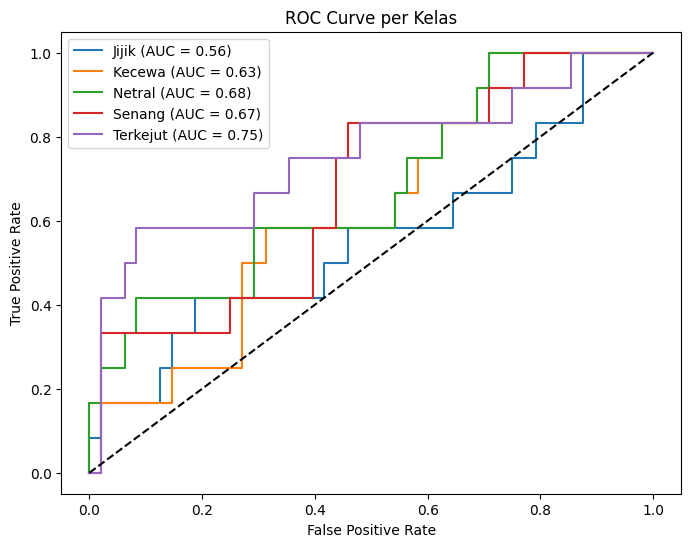

In [108]:
plt.figure(figsize=(8,6))
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test_hybrid[:, i], y_pred_proba_hybrid[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Kelas')
plt.legend()
plt.show()

# Perbandingan Kinerja antar Model CNN + LSTM

In [109]:
# Kumpulkan semua metrik ke dalam dictionary
metrics_data = {
    'Model': ['CNN-MFCC+Hilbert', 'CNN-MFCC+Cochleagram', 'CNN-Hilbert+Cochleagram', 'CNN-Hybrid', 'LSTM-MFCC+Hilbert', 'LSTM-MFCC+Cochleagram', 'LSTM-Hilbert+Cochleagram', 'LSTM-Hybrid', 'Hybrid (CNN+LSTM)'],
    'Akurasi': [
        accuracy_score(y_true_cnn_mfcc_hilbert, y_pred_cnn_mfcc_hilbert),
        accuracy_score(y_true_cnn_mfcc_cochleagram, y_pred_cnn_mfcc_cochleagram),
        accuracy_score(y_true_cnn_hilbert_cochleagram, y_pred_cnn_hilbert_cochleagram),
        accuracy_score(y_true_cnn_hybrid, y_pred_cnn_hybrid),
        accuracy_score(y_true_lstm_mfcc_hilbert, y_pred_lstm_mfcc_hilbert),
        accuracy_score(y_true_lstm_mfcc_cochleagram, y_pred_lstm_mfcc_cochleagram),
        accuracy_score(y_true_lstm_hilbert_cochleagram, y_pred_lstm_hilbert_cochleagram),
        accuracy_score(y_true_lstm_hybrid, y_pred_lstm_hybrid),
        accuracy_score(y_true_hybrid, y_pred_hybrid)
    ],
    'Precision (macro)': [
        precision_score(y_true_cnn_mfcc_hilbert, y_pred_cnn_mfcc_hilbert, average='macro'),
        precision_score(y_true_cnn_mfcc_cochleagram, y_pred_cnn_mfcc_cochleagram, average='macro'),
        precision_score(y_true_cnn_hilbert_cochleagram, y_pred_cnn_hilbert_cochleagram, average='macro'),
        precision_score(y_true_cnn_hybrid, y_pred_cnn_hybrid, average='macro'),
        precision_score(y_true_lstm_mfcc_hilbert, y_pred_lstm_mfcc_hilbert, average='macro'),
        precision_score(y_true_lstm_mfcc_cochleagram, y_pred_lstm_mfcc_cochleagram, average='macro'),
        precision_score(y_true_lstm_hilbert_cochleagram, y_pred_lstm_hilbert_cochleagram, average='macro'),
        precision_score(y_true_lstm_hybrid, y_pred_lstm_hybrid, average='macro'),
        precision_score(y_true_hybrid, y_pred_hybrid, average='macro')
    ],
    'Recall (macro)': [
        recall_score(y_true_cnn_mfcc_hilbert, y_pred_cnn_mfcc_hilbert, average='macro'),
        recall_score(y_true_cnn_mfcc_cochleagram, y_pred_cnn_mfcc_cochleagram, average='macro'),
        recall_score(y_true_cnn_hilbert_cochleagram, y_pred_cnn_hilbert_cochleagram, average='macro'),
        recall_score(y_true_cnn_hybrid, y_pred_cnn_hybrid, average='macro'),
        recall_score(y_true_lstm_mfcc_hilbert, y_pred_lstm_mfcc_hilbert, average='macro'),
        recall_score(y_true_lstm_mfcc_cochleagram, y_pred_lstm_mfcc_cochleagram, average='macro'),
        recall_score(y_true_lstm_hilbert_cochleagram, y_pred_lstm_hilbert_cochleagram, average='macro'),
        recall_score(y_true_lstm_hybrid, y_pred_lstm_hybrid, average='macro'),
        recall_score(y_true_hybrid, y_pred_hybrid, average='macro')
    ],
    'F1-score (macro)': [
        f1_score(y_true_cnn_mfcc_hilbert, y_pred_cnn_mfcc_hilbert, average='macro'),
        f1_score(y_true_cnn_mfcc_cochleagram, y_pred_cnn_mfcc_cochleagram, average='macro'),
        f1_score(y_true_cnn_hilbert_cochleagram, y_pred_cnn_hilbert_cochleagram, average='macro'),
        f1_score(y_true_cnn_hybrid, y_pred_cnn_hybrid, average='macro'),
        f1_score(y_true_lstm_mfcc_hilbert, y_pred_lstm_mfcc_hilbert, average='macro'),
        f1_score(y_true_lstm_mfcc_cochleagram, y_pred_lstm_mfcc_cochleagram, average='macro'),
        f1_score(y_true_lstm_hilbert_cochleagram, y_pred_lstm_hilbert_cochleagram, average='macro'),
        f1_score(y_true_lstm_hybrid, y_pred_lstm_hybrid, average='macro'),
        f1_score(y_true_hybrid, y_pred_hybrid, average='macro')
    ],
    'AUC-ROC (macro)': [
        roc_auc_score(y_test_mfcc_hilbert, y_pred_proba_cnn_mfcc_hilbert, average='macro', multi_class='ovr'),
        roc_auc_score(y_test_mfcc_cochleagram, y_pred_proba_cnn_mfcc_cochleagram, average='macro', multi_class='ovr'),
        roc_auc_score(y_test_hilbert_cochleagram, y_pred_proba_cnn_hilbert_cochleagram, average='macro', multi_class='ovr'),
        roc_auc_score(y_test_hybrid, y_pred_proba_cnn_hybrid, average='macro', multi_class='ovr'),
        roc_auc_score(y_test_mfcc_hilbert, y_pred_proba_lstm_mfcc_hilbert, average='macro', multi_class='ovr'),
        roc_auc_score(y_test_mfcc_cochleagram, y_pred_proba_lstm_mfcc_cochleagram, average='macro', multi_class='ovr'),
        roc_auc_score(y_test_hilbert_cochleagram, y_pred_proba_lstm_hilbert_cochleagram, average='macro', multi_class='ovr'),
        roc_auc_score(y_test_hybrid, y_pred_proba_lstm_hybrid, average='macro', multi_class='ovr'),
        roc_auc_score(y_test_hybrid, y_pred_proba_hybrid, average='macro', multi_class='ovr')
    ]
}

In [110]:
# Buat DataFrame
comparison_df = pd.DataFrame(metrics_data)
print("Tabel Perbandingan Kinerja Model:")
print(comparison_df.to_string())

Tabel Perbandingan Kinerja Model:
                      Model   Akurasi  Precision (macro)  Recall (macro)  F1-score (macro)  AUC-ROC (macro)
0          CNN-MFCC+Hilbert  0.466667           0.500696        0.466667          0.465544         0.801736
1      CNN-MFCC+Cochleagram  0.833333           0.844918        0.833333          0.832913         0.963889
2   CNN-Hilbert+Cochleagram  0.283333           0.238664        0.283333          0.238561         0.656250
3                CNN-Hybrid  0.433333           0.436667        0.433333          0.424561         0.798958
4         LSTM-MFCC+Hilbert  0.383333           0.161330        0.383333          0.227073         0.746528
5     LSTM-MFCC+Cochleagram  0.416667           0.468822        0.416667          0.406406         0.708333
6  LSTM-Hilbert+Cochleagram  0.200000           0.040000        0.200000          0.066667         0.708507
7               LSTM-Hybrid  0.200000           0.040000        0.200000          0.066667         0.6

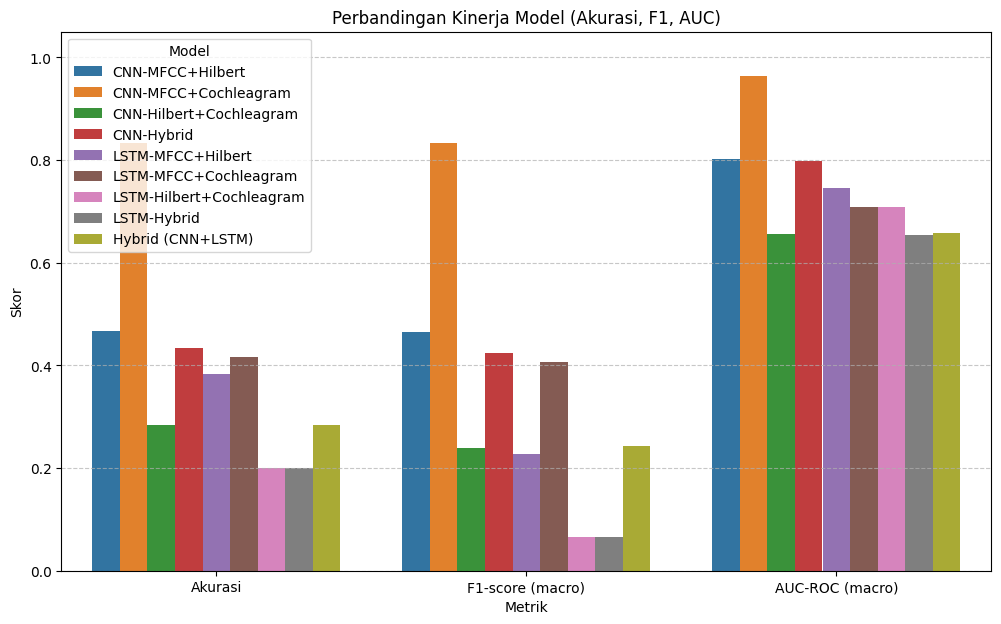

In [111]:
# Siapkan data untuk plot
plot_df = comparison_df.melt(id_vars='Model', value_vars=['Akurasi', 'F1-score (macro)', 'AUC-ROC (macro)'],
                             var_name='Metrik', value_name='Skor')

# Buat bar plot
plt.figure(figsize=(12, 7))
sns.barplot(data=plot_df, x='Metrik', y='Skor', hue='Model')
plt.title('Perbandingan Kinerja Model (Akurasi, F1, AUC)')
plt.ylabel('Skor')
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [112]:
# Siapkan probabilitas dari setiap model
models_proba = {
    'CNN-MFCC+Hilbert': y_pred_proba_cnn_mfcc_hilbert,
    'CNN-MFCC+Cochleagram': y_pred_proba_cnn_mfcc_cochleagram,
    'CNN-Hilbert+Cochleagram': y_pred_proba_cnn_hilbert_cochleagram,
    'CNN': y_pred_proba_cnn_hybrid,
    'LSTM-MFCC+Hilbert': y_pred_proba_lstm_mfcc_hilbert,
    'LSTM-MFCC+Cochleagram':y_pred_proba_lstm_mfcc_cochleagram,
    'LSTM-Hilbert+Cochleagram':y_pred_proba_lstm_hilbert_cochleagram,
    'LSTM': y_pred_proba_lstm_hybrid,
    'Hybrid (CNN+LSTM)': y_pred_proba_hybrid
}

In [113]:
plt.figure(figsize=(10, 8))

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

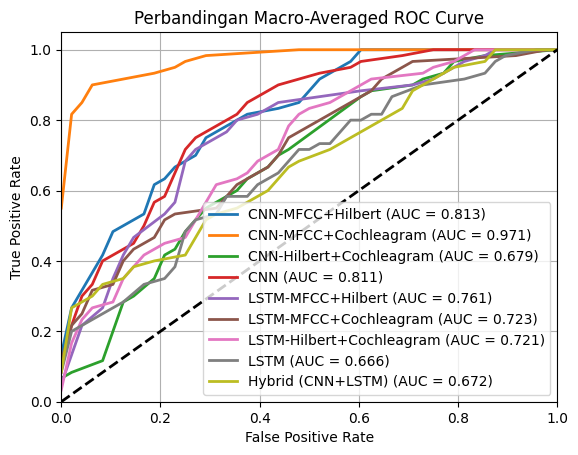

In [114]:
# Loop untuk setiap model
for model_name, y_pred_proba in models_proba.items():
    # Hitung macro-average ROC
    n_classes = y_test_hybrid.shape[1]
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_hybrid[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    
    macro_auc = auc(all_fpr, mean_tpr)

    # Plot ROC curve
    plt.plot(all_fpr, mean_tpr,
             label=f'{model_name} (AUC = {macro_auc:.3f})',
             linewidth=2)

# Plot garis referensi
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Perbandingan Macro-Averaged ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()